<img src="https://www.mmu.edu.my/fci/wp-content/uploads/2021/01/FCI_wNEW_MMU_LOGO.png" style="height: 80px;" align=left>  

## Assignment Objective
The aim of this assignment is to guide you through the process of understanding a dataset,
performing preprocessing, building classification models, including ensemble learning techniques,
and evaluation using cross-validation and various metrics.

In [1]:
# pip install imbalanced-learn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


# Data Exploration

In [2]:
# statistics and visualization

In [3]:
df = pd.read_csv('Student_dataset.csv')
df.head()

Marital status  Application mode  Application order  Course  \
0               1              17.0                  5   171.0   
1               1              15.0                  1  9254.0   
2               1               1.0                  5  9070.0   
3               1              17.0                  2  9773.0   
4               2              39.0                  1  8014.0   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                    19.0   
1                           160.0            1                     1.0   
2                           122.0            1                    37.0   
3                           122.0            1                    38.0   
4                           100.0            1                    37.0   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      12  ...                                    0   
1                       3  ...                                    0   
2                      37  ...                                    0   
3                      37  ...                                    0   
4                      38  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP    Target  
0             1.4  1.74   Dropout  
1            -0.3  0.79  Graduate  
2             1.4  1.74   Dropout  
3            -0.8 -3.12  Graduate  
4            -0.3  0.79  Graduate  

[5 rows x 37 columns]

In [4]:
numerical_columns= df.select_dtypes(['int64','float64']).columns
print(f"List of numerical attributes\n")
print(f"{numerical_columns}\n")

List of numerical attributes

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)'

In [5]:
# Initialize categories
continuous_features = []
ordinal_features = []
ratio_features = []
binary_features = []

# Categorize features
for col in df.columns:
    unique_vals = df[col].nunique()
    if df[col].dtype in ['float64']:
        if unique_vals == 2:
            binary_features.append(col)  # Binary (Yes/No, Male/Female)
        elif unique_vals > 10:
            if col.lower().endswith(('grade', '(grade)', 'score')):
                continuous_features.append(col)  # Likely Continuous
            else:
                ratio_features.append(col)  # Likely Ratio
        else:
            ordinal_features.append(col)  # Small range, likely Ordinal
    elif df[col].dtype == 'int64':
        if unique_vals == 2:
            binary_features.append(col)  # Binary categorical
        else:
            ordinal_features.append(col)  # Ordinal categorical

# Print categorized features
print("Continuous Features:", continuous_features)
print("Ordinal Features:", ordinal_features)
print("Ratio Features:", ratio_features)
print("Binary Features:", binary_features)


Continuous Features: ['Previous qualification (grade)', 'Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']
Ordinal Features: ['Marital status', 'Application order', 'Previous qualification', 'Nacionality', "Father's qualification", "Mother's occupation", "Father's occupation", 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
Ratio Features: ['Application mode', 'Course', "Mother's qualification", 'Age at enrollment']
Binary Features: ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to da

In [6]:
describe = df.describe()
describe

Marital status  Application mode  Application order       Course  \
count     4446.000000       4444.000000         4446.00000  4440.000000   
mean         1.179037         18.663816            1.72717  8858.807432   
std          0.606208         17.490937            1.31343  2060.398841   
min          1.000000          1.000000            0.00000    33.000000   
25%          1.000000          1.000000            1.00000  9085.000000   
50%          1.000000         17.000000            1.00000  9238.000000   
75%          1.000000         39.000000            2.00000  9556.000000   
max          6.000000         57.000000            9.00000  9991.000000   

       Daytime/evening attendance\t  Previous qualification  \
count                   4446.000000             4446.000000   
mean                       0.891138                4.585245   
std                        0.311501               10.224512   
min                        0.000000                1.000000   
25%                        1.000000                1.000000   
50%                        1.000000                1.000000   
75%                        1.000000                1.000000   
max                        1.000000               43.000000   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
count                     4439.000000  4446.000000             4443.000000   
mean                       132.640572     1.896986               19.552104   
std                         13.221879     7.075343               15.610384   
min                         95.000000     1.000000                1.000000   
25%                        125.000000     1.000000                2.000000   
50%                        133.100000     1.000000               19.000000   
75%                        140.000000     1.000000               37.000000   
max                        190.000000   109.000000               44.000000   

       Father's qualification  ...  \
count             4446.000000  ...   
mean                22.284300  ...   
std                 15.345329  ...   
min                  1.000000  ...   
25%                  3.000000  ...   
50%                 19.000000  ...   
75%                 37.000000  ...   
max                 44.000000  ...   

       Curricular units 1st sem (without evaluations)  \
count                                     4446.000000   
mean                                         0.137427   
std                                          0.689473   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                         12.000000   

       Curricular units 2nd sem (credited)  \
count                          4446.000000   
mean                              0.543860   
std                               1.921926   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          4446.000000   
mean                              6.234818   
std                               2.194935   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             4446.000000   
mean                                 8.065902   
std                                  3.941864   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                           

C:\Users\nasih\AppData\Local\Temp\ipykernel_39064\3709721819.py:47: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


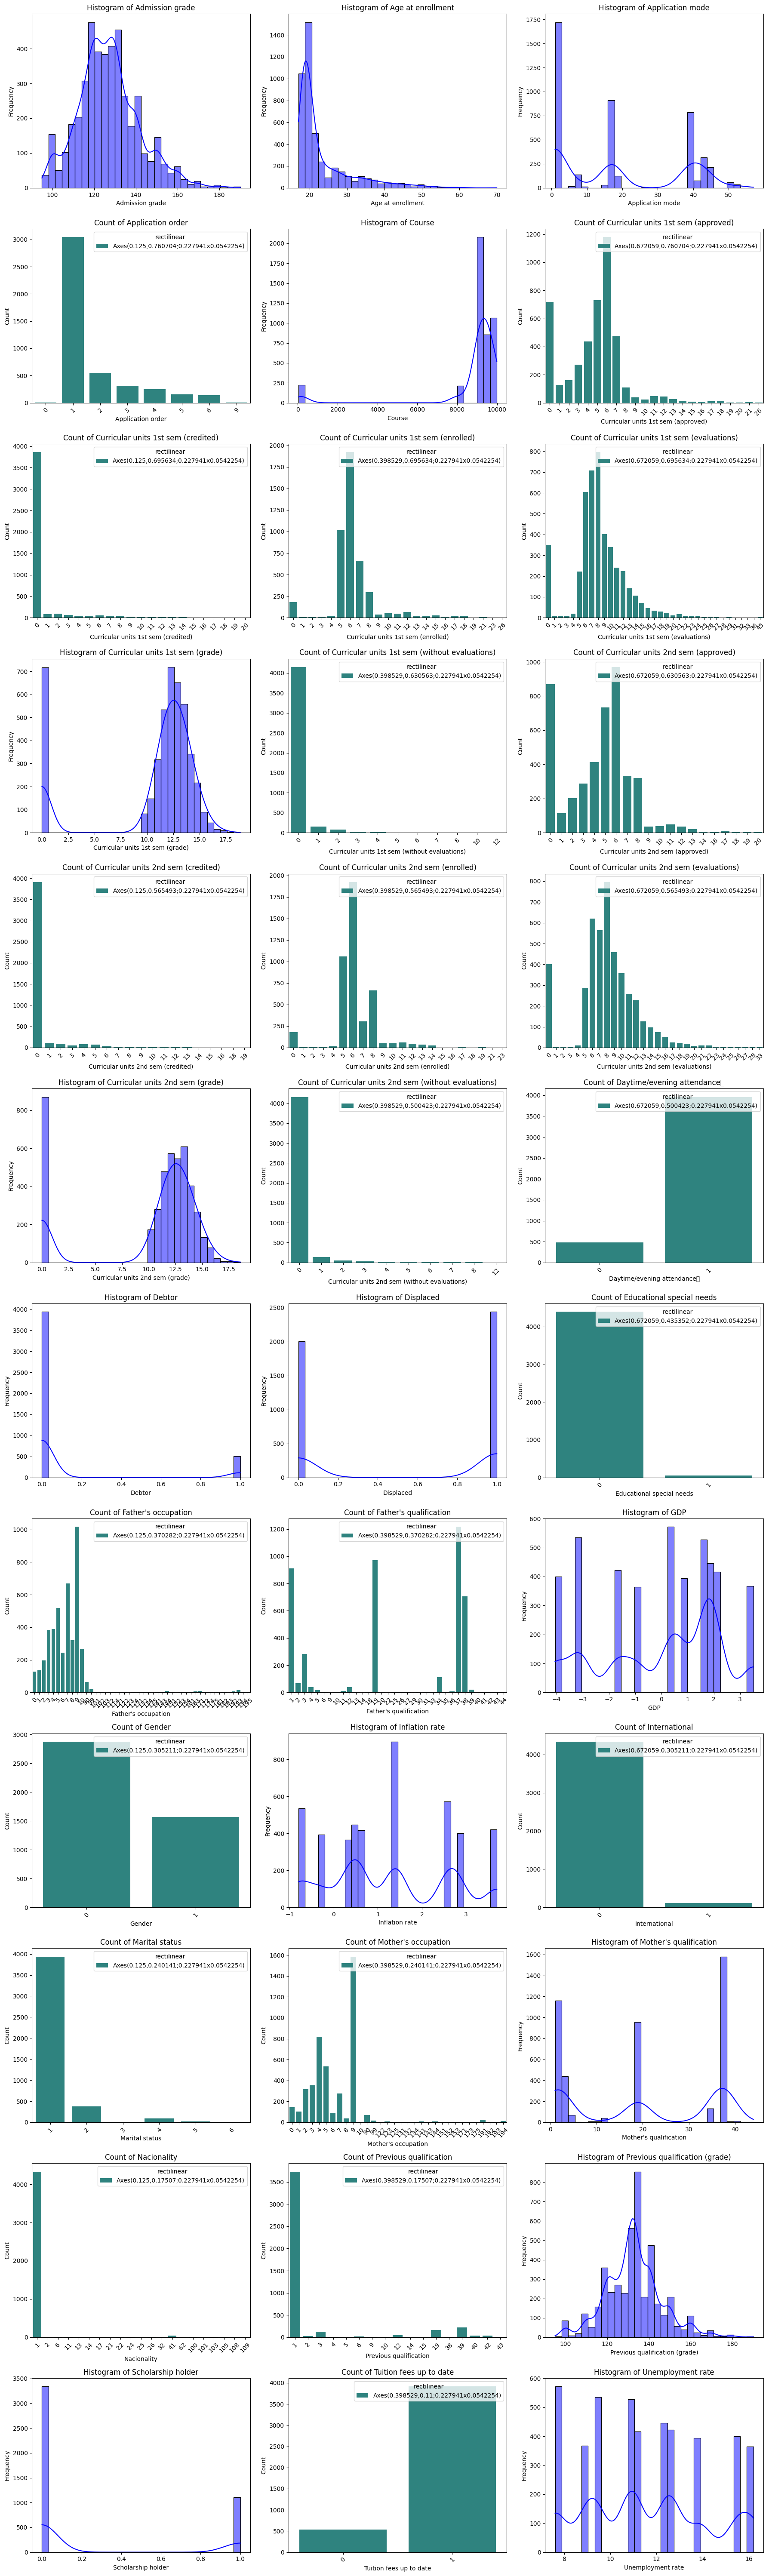

In [7]:
# Combine both for a single visualization layout
float_columns = df.select_dtypes(['float64'])
int_columns = df.select_dtypes(['int64'])
numerical_columns = float_columns + int_columns
all_columns = list(numerical_columns)

# Define the layout
columns_per_row = 3  # Number of plots per row
num_columns = len(all_columns)
num_rows = math.ceil(num_columns / columns_per_row)
# Create subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot each attribute
for idx, column in enumerate(all_columns):
    ax = axes[idx]
    
    if column in float_columns:
        # Plot histograms with KDE for numerical columns
        sns.histplot(df[column], kde=True, ax=ax, bins=30, color='blue')
        ax.set_title(f"Histogram of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
    elif column in int_columns:
        # Plot count plots for categorical columns
        sns.countplot(x=df[column], ax=ax, palette="viridis", hue=ax)
        ax.set_title(f"Count of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        # Rotate labels for better visibility
        ax.tick_params(axis='x', rotation=45)
    elif column in categorical_columns:
        # Plot count plots for categorical columns
        sns.countplot(x=df[column], ax=ax, palette="viridis", hue=ax)
        ax.set_title(f"Count of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        # Rotate labels for better visibility
        ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for idx in range(num_columns, len(axes)):
    axes[idx].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\nasih\AppData\Local\Temp\ipykernel_39064\3426522432.py:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


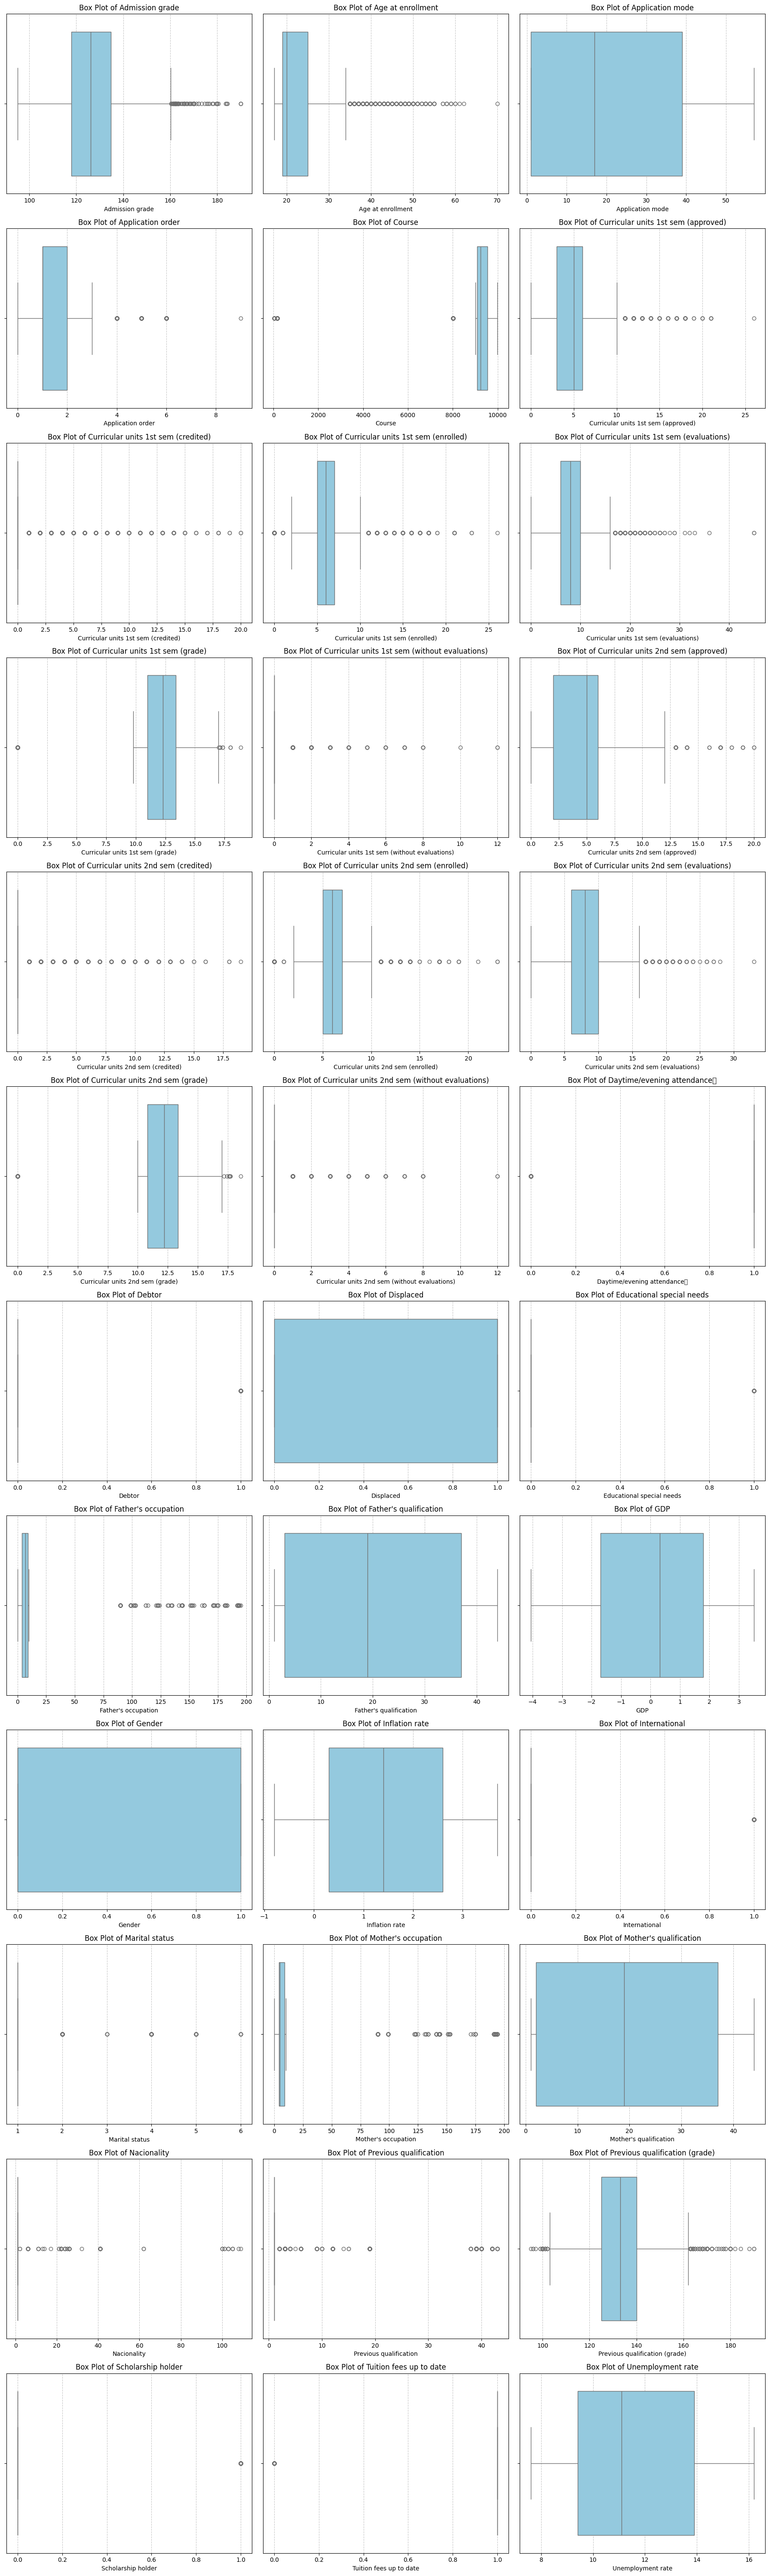

In [8]:
# Create subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot boxplots for numerical columns
for idx, column in enumerate(numerical_columns):
    ax = axes[idx]  # Select the appropriate subplot
    sns.boxplot(x=df[column], ax=ax, color='skyblue')  # Boxplot for each numerical column
    ax.set_title(f"Box Plot of {column}")
    ax.set_xlabel(column)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Hide unused subplots
for idx in range(num_columns, len(axes)):
    axes[idx].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

Chosen box plot with complete 5 values min, max, median, Q1, Q3

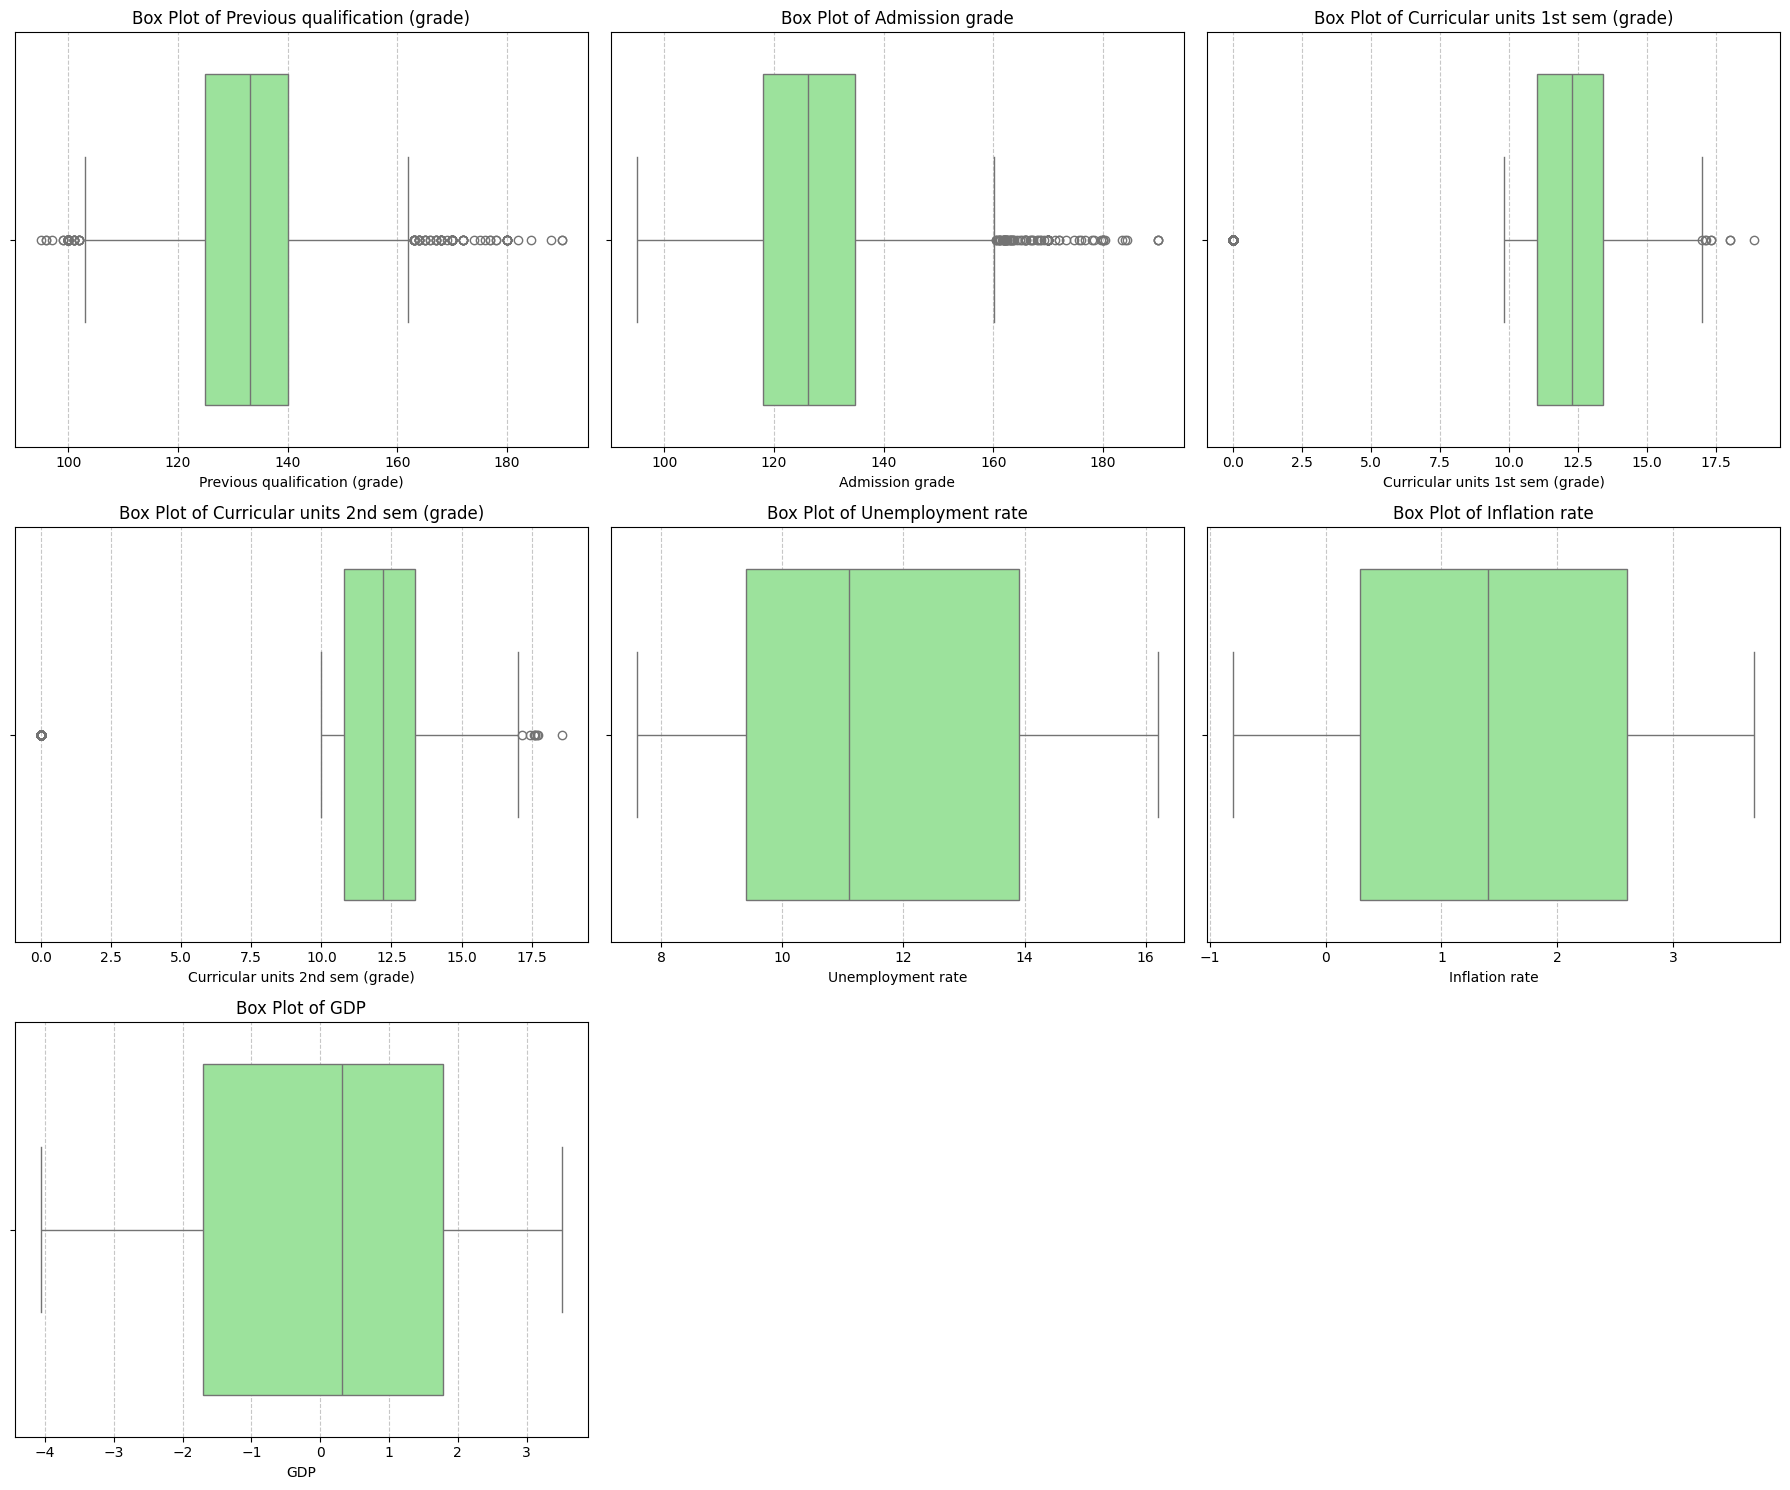

In [9]:
# Define continuous features (manually or dynamically)

continuous_features = [ 'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP']  # Replace this with your continuous feature names

# Check if the continuous features exist in the dataset
continuous_features = [col for col in continuous_features if col in df.columns]

# Define the layout
columns_per_row = 3  # Number of plots per row
num_features = len(continuous_features)
num_rows = math.ceil(num_features / columns_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot boxplots for continuous features
for idx, column in enumerate(continuous_features):
    ax = axes[idx]  # Select the appropriate subplot
    sns.boxplot(x=df[column], ax=ax, color='lightgreen')  # Boxplot for each continuous feature
    ax.set_title(f"Box Plot of {column}")
    ax.set_xlabel(column)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Hide unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

#### Categorical Description

In [10]:
#exploring categotical data
categorical_columns = df.select_dtypes(['object']).describe()
categorical_columns

Target
count       4446
unique         3
top     Graduate
freq        2221

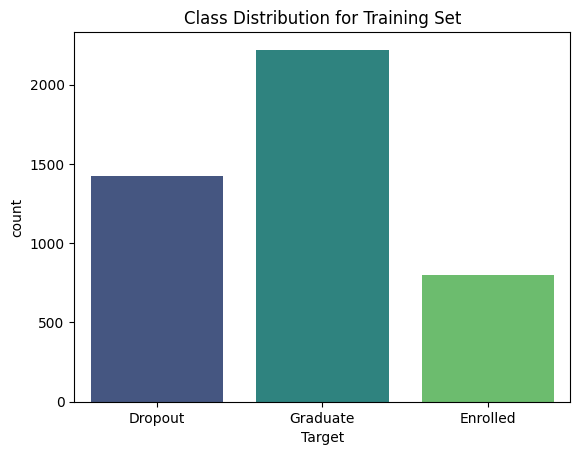

In [11]:
plt.figure()
sns.countplot(  data=df, x='Target', hue='Target', palette='viridis', dodge=False, )
plt.title('Class Distribution for Training Set')
plt.show()

### Correlation analysis

In [12]:
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr(method = 'pearson')

C:\Anaconda\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


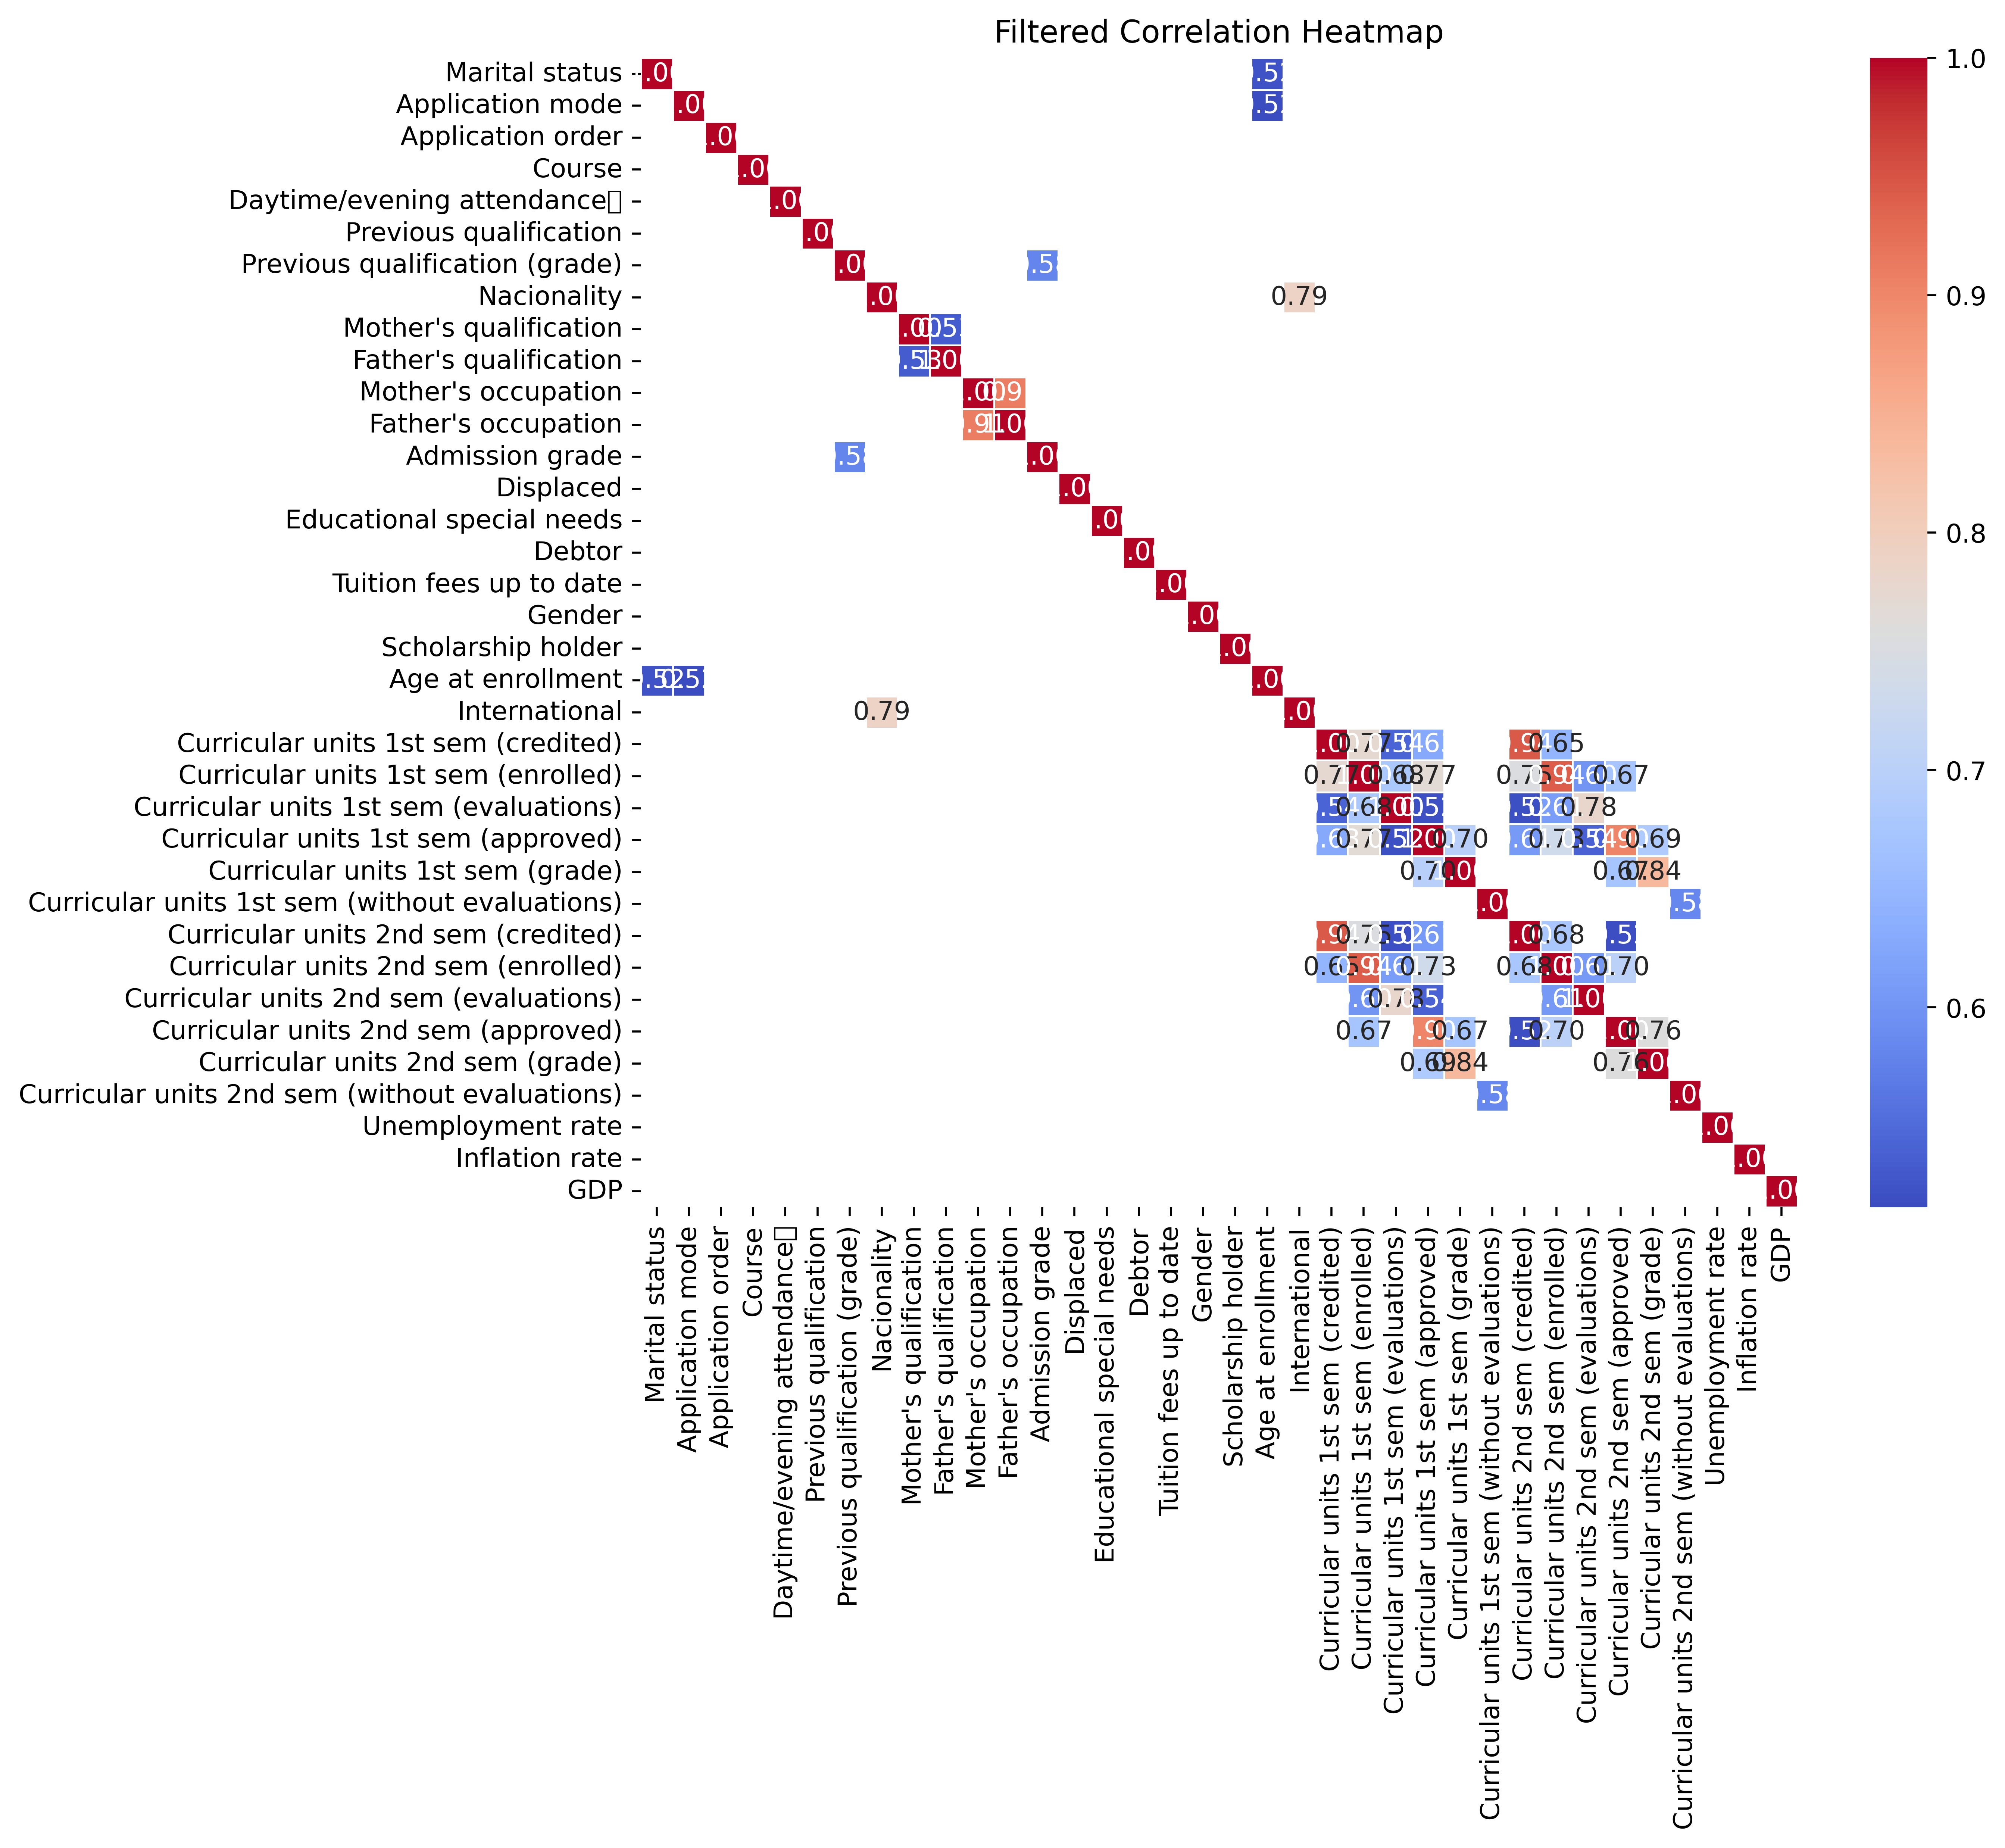

In [13]:
corr_threshold = 0.5
filtered_corr = corr[(corr > corr_threshold) | (corr < -corr_threshold)]

plt.figure(figsize=(10, 8), dpi=500)
sns.heatmap(filtered_corr, annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm", mask=filtered_corr.isnull())
plt.title("Filtered Correlation Heatmap")
plt.show()

### Top 10 Correlation score

In [14]:
# Flatten the correlation matrix and sort
corr_flat = corr.unstack().reset_index()
corr_flat.columns = ['Attribute 1', 'Attribute 2', 'Correlation']
corr_flat['AbsCorrelation'] = corr_flat['Correlation'].abs()

# Remove duplicates (e.g., "Attribute A - Attribute B" and "Attribute B - Attribute A")
corr_flat = corr_flat[corr_flat['Attribute 1'] != corr_flat['Attribute 2']]  # Remove self-correlations
top_10_corr = corr_flat.sort_values(by='AbsCorrelation', ascending=False).head(20)
corr_flat = corr_flat.drop_duplicates(subset=['AbsCorrelation'])

# Sort by absolute correlation and select the top 10
top_10_unique_corr = corr_flat.sort_values(by='AbsCorrelation', ascending=False).head(10)

# Display the top 10 correlations
print("Top 10 Highest Correlations:")
top_10_unique_corr[['Attribute 1', 'Attribute 2', 'Correlation']]

Top 10 Highest Correlations:


Attribute 1  \
783      Curricular units 1st sem (credited)   
820      Curricular units 1st sem (enrolled)   
371                      Mother's occupation   
894      Curricular units 1st sem (approved)   
931         Curricular units 1st sem (grade)   
272                              Nacionality   
857   Curricular units 1st sem (evaluations)   
778      Curricular units 1st sem (credited)   
816      Curricular units 1st sem (enrolled)   
1111     Curricular units 2nd sem (approved)   

                                 Attribute 2  Correlation  
783      Curricular units 2nd sem (credited)     0.944527  
820      Curricular units 2nd sem (enrolled)     0.942590  
371                      Father's occupation     0.910450  
894      Curricular units 2nd sem (approved)     0.903340  
931         Curricular units 2nd sem (grade)     0.837285  
272                            International     0.788719  
857   Curricular units 2nd sem (evaluations)     0.778841  
778      Curricular units 1st sem (enrolled)     0.774612  
816      Curricular units 1st sem (approved)     0.768841  
1111        Curricular units 2nd sem (grade)     0.759691

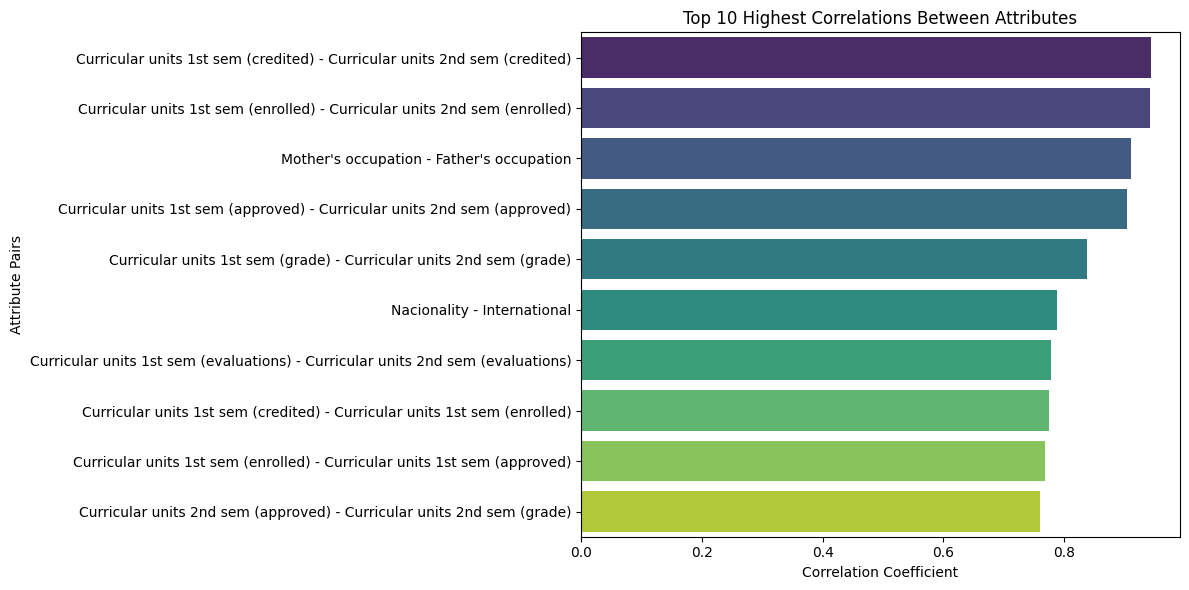

In [15]:
# Plot the Top 10 Correlations
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_unique_corr['Correlation'], 
    y=top_10_unique_corr.apply(lambda x: f"{x['Attribute 1']} - {x['Attribute 2']}", axis=1),
    palette="viridis", hue =top_10_unique_corr.apply(lambda x: f"{x['Attribute 1']} - {x['Attribute 2']}", axis=1)
)
plt.title("Top 10 Highest Correlations Between Attributes")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Attribute Pairs")
plt.tight_layout()
plt.show()

### Heatmap Correlation

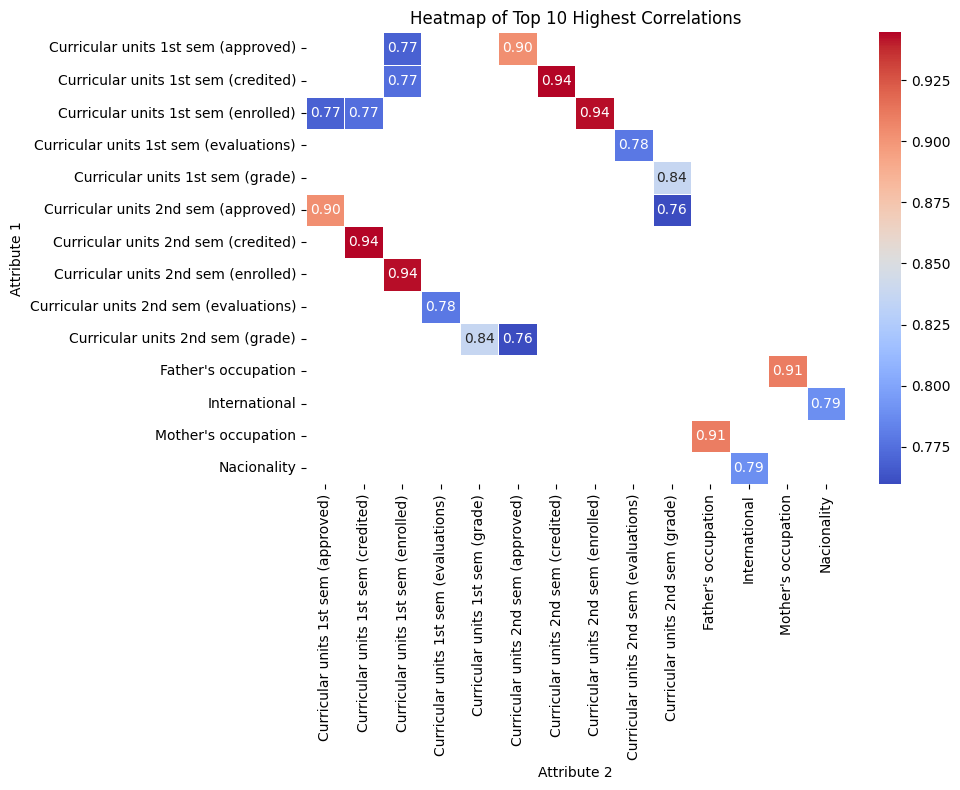

In [16]:
# Create a pivot table for the heatmap
heatmap_data = top_10_corr.pivot(index = "Attribute 1", columns="Attribute 2",values = "Correlation")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Top 10 Highest Correlations")
plt.tight_layout()
plt.show()

# Data Preprocessing

## cleaning, normalization, missing data, duplication, etc)

### List of datatypes, duplicates and Null-values

In [17]:
def summarize_columns(dataframe):
    """Summarizes the columns in the dataframe with detailed insights."""
    summary = []
    for column in dataframe.columns:
        dtype = dataframe[column].dtype
        missing_count = dataframe[column].isnull().sum()
        non_missing_count = dataframe[column].notnull().sum()
        unique_values = dataframe[column].nunique()

        if unique_values <= 10:  # If fewer than 10 unique values, show all counts
            values_counts = dataframe[column].value_counts().to_dict()
        else:  # Otherwise, show the top 5 most frequent values
            values_counts = dataframe[column].value_counts().nlargest(5).to_dict()

        summary.append({
            'Column Name': column,
            'Data Type': dtype,
            'Missing Values': missing_count,
            'Non-Missing Values': non_missing_count,
            'Unique Values': unique_values,
            'Top Values (or All if <=10)': values_counts
        })

    return pd.DataFrame(summary)

# Example usage
column_summary = summarize_columns(df)
column_summary

Column Name Data Type  Missing Values  \
0                                   Marital status     int64               0   
1                                 Application mode   float64               2   
2                                Application order     int64               0   
3                                           Course   float64               6   
4                     Daytime/evening attendance\t     int64               0   
5                           Previous qualification     int64               0   
6                   Previous qualification (grade)   float64               7   
7                                      Nacionality     int64               0   
8                           Mother's qualification   float64               3   
9                           Father's qualification     int64               0   
10                             Mother's occupation     int64               0   
11                             Father's occupation     int64               0   
12                                 Admission grade   float64              18   
13                                       Displaced   float64               3   
14                       Educational special needs     int64               0   
15                                          Debtor   float64               2   
16                         Tuition fees up to date     int64               0   
17                                          Gender     int64               0   
18                              Scholarship holder   float64               2   
19                               Age at enrollment   float64               4   
20                                   International     int64               0   
21             Curricular units 1st sem (credited)     int64               0   
22             Curricular units 1st sem (enrolled)     int64               0   
23          Curricular units 1st sem (evaluations)     int64               0   
24             Curricular units 1st sem (approved)     int64               0   
25                Curricular units 1st sem (grade)   float64               0   
26  Curricular units 1st sem (without evaluations)     int64               0   
27             Curricular units 2nd sem (credited)     int64               0   
28             Curricular units 2nd sem (enrolled)     int64               0   
29          Curricular units 2nd sem (evaluations)     int64               0   
30             Curricular units 2nd sem (approved)     int64               0   
31                Curricular units 2nd sem (grade)   float64               0   
32  Curricular units 2nd sem (without evaluations)     int64               0   
33                               Unemployment rate   float64               0   
34                                  Inflation rate   float64               0   
35                                             GDP   float64               0   
36                                          Target    object               0   

    Non-Missing Values  Unique Values  \
0                 4446              6   
1                 4444             18   
2                 4446              8   
3                 4440             17   
4                 4446              2   
5                 4446             17   
6                 4439            101   
7                 4446             21   
8                 4443             29   
9                 4446             34   
10                4446             32   
11                4446             46   
12                4428            620   
13                4443              2   
14                4446              2   
15                4444              2   
16                4446              2   
17                4446              2   
18                4444              2   
19                4442             46   
20                4446              2   
21                4446             21   
22                4446             23   
23            

### List of data contained Null-values

##### From the above we can observe the list of attributes that contain NaN values: 
* Application mode
* Course
* Previous qualification (grade)
* Mother's qualification
* Admission grade
* Displaced
* Debtor
* Scholarship holder 
* Age at enrollment


### Fill in Null-values with mean, median, mode (numerical attributes)

In [18]:
def fillna_by_feature_type(df, feature_types):
    
    for feature_type, features in feature_types.items():
        for feature in features:
            if feature in df.columns:
                if feature_type == 'ratio' or feature_type == 'continuous':
                    # Fill with mean or median
                    if df[feature].dtype in ['float64', 'int64']:
                        df[feature] = df[feature].fillna(df[feature].mean())
                    else:
                        df[feature] = df[feature].fillna(df[feature].median())
                elif feature_type == 'ordinal':
                    # Fill with median or mode
                    mode = df[feature].mode()[0]
                    df[feature] = df[feature].fillna(df[feature].median() if df[feature].dtype in ['float64', 'int64'] else mode)
                elif feature_type == 'binary':
                    # Fill with mode
                    df[feature] = df[feature].fillna(df[feature].mode()[0])
    return df

feature_types = {
    'continuous': continuous_features,
    'ordinal': ordinal_features,
    'ratio': ratio_features,
    'binary': binary_features
}

# Fill missing values
df_filled = fillna_by_feature_type(df, feature_types)

##### Attributes with wrong dtypes from the description
* Application mode float64 -> int64
* Course float64 -> int64
* Mother's qualification float64 -> int64
* Displaced float64 -> int64
* Debtor float64 -> int64
* Scholarship holder float64 -> int64
* Age at enrollment float64 -> int64

In [19]:
# Define columns to convert
columns_to_convert = ['Application mode', 'Course', "Mother's qualification", 
                      'Displaced', 'Debtor', 'Scholarship holder', 'Age at enrollment']

# Replace NaN with 0 and convert to integer
df_filled[columns_to_convert] = df_filled[columns_to_convert].astype('int64')

#### Missing Value after cleaning

In [20]:
after_cleaning = summarize_columns(df_filled)
after_cleaning

Column Name Data Type  Missing Values  \
0                                   Marital status     int64               0   
1                                 Application mode     int64               0   
2                                Application order     int64               0   
3                                           Course     int64               0   
4                     Daytime/evening attendance\t     int64               0   
5                           Previous qualification     int64               0   
6                   Previous qualification (grade)   float64               0   
7                                      Nacionality     int64               0   
8                           Mother's qualification     int64               0   
9                           Father's qualification     int64               0   
10                             Mother's occupation     int64               0   
11                             Father's occupation     int64               0   
12                                 Admission grade   float64               0   
13                                       Displaced     int64               0   
14                       Educational special needs     int64               0   
15                                          Debtor     int64               0   
16                         Tuition fees up to date     int64               0   
17                                          Gender     int64               0   
18                              Scholarship holder     int64               0   
19                               Age at enrollment     int64               0   
20                                   International     int64               0   
21             Curricular units 1st sem (credited)     int64               0   
22             Curricular units 1st sem (enrolled)     int64               0   
23          Curricular units 1st sem (evaluations)     int64               0   
24             Curricular units 1st sem (approved)     int64               0   
25                Curricular units 1st sem (grade)   float64               0   
26  Curricular units 1st sem (without evaluations)     int64               0   
27             Curricular units 2nd sem (credited)     int64               0   
28             Curricular units 2nd sem (enrolled)     int64               0   
29          Curricular units 2nd sem (evaluations)     int64               0   
30             Curricular units 2nd sem (approved)     int64               0   
31                Curricular units 2nd sem (grade)   float64               0   
32  Curricular units 2nd sem (without evaluations)     int64               0   
33                               Unemployment rate   float64               0   
34                                  Inflation rate   float64               0   
35                                             GDP   float64               0   
36                                          Target    object               0   

    Non-Missing Values  Unique Values  \
0                 4446              6   
1                 4446             18   
2                 4446              8   
3                 4446             18   
4                 4446              2   
5                 4446             17   
6                 4446            102   
7                 4446             21   
8                 4446             29   
9                 4446             34   
10                4446             32   
11                4446             46   
12                4446            621   
13                4446              2   
14                4446              2   
15                4446              2   
16                4446              2   
17                4446              2   
18                4446              2   
19                4446             46   
20                4446              2   
21                4446             21   
22                4446             23   
23            

#### Checking duplicated row

In [21]:
df2  = df_filled.copy()
# Check for duplicate rows
duplicates = df2.duplicated().sum()

# Display rows that are duplicates
print(f"Numbers of duplicated Rows: {duplicates}")

Numbers of duplicated Rows: 22


In [22]:
after_drop = df2.drop_duplicates()
print(f"Numbers of duplicates after drop {after_drop.shape}")

Numbers of duplicates after drop (4424, 37)


#### Numerical attributes description/normalization (After cleaning and drop)

In [23]:
df3 = after_drop
df3.describe()

Marital status  Application mode  Application order       Course  \
count     4424.000000       4424.000000        4424.000000  4424.000000   
mean         1.178571         18.658680           1.727848  8858.075045   
std          0.605747         17.478184           1.313793  2059.355868   
min          1.000000          1.000000           0.000000    33.000000   
25%          1.000000          1.000000           1.000000  9085.000000   
50%          1.000000         17.000000           1.000000  9238.000000   
75%          1.000000         39.000000           2.000000  9556.000000   
max          6.000000         57.000000           9.000000  9991.000000   

       Daytime/evening attendance\t  Previous qualification  \
count                   4424.000000             4424.000000   
mean                       0.890823                4.577758   
std                        0.311897               10.216592   
min                        0.000000                1.000000   
25%                        1.000000                1.000000   
50%                        1.000000                1.000000   
75%                        1.000000                1.000000   
max                        1.000000               43.000000   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
count                     4424.000000  4424.000000             4424.000000   
mean                       132.610259     1.873192               19.548825   
std                         13.181416     6.914514               15.595493   
min                         95.000000     1.000000                1.000000   
25%                        125.000000     1.000000                2.000000   
50%                        133.100000     1.000000               19.000000   
75%                        140.000000     1.000000               37.000000   
max                        190.000000   109.000000               44.000000   

       Father's qualification  ...  \
count             4424.000000  ...   
mean                22.275316  ...   
std                 15.343108  ...   
min                  1.000000  ...   
25%                  3.000000  ...   
50%                 19.000000  ...   
75%                 37.000000  ...   
max                 44.000000  ...   

       Curricular units 1st sem (without evaluations)  \
count                                     4424.000000   
mean                                         0.137658   
std                                          0.690880   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                         12.000000   

       Curricular units 2nd sem (credited)  \
count                          4424.000000   
mean                              0.541817   
std                               1.918546   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          4424.000000   
mean                              6.232143   
std                               2.195951   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             4424.000000   
mean                                 8.063291   
std                                  3.947951   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                           

C:\Users\nasih\AppData\Local\Temp\ipykernel_39064\1036611256.py:47: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


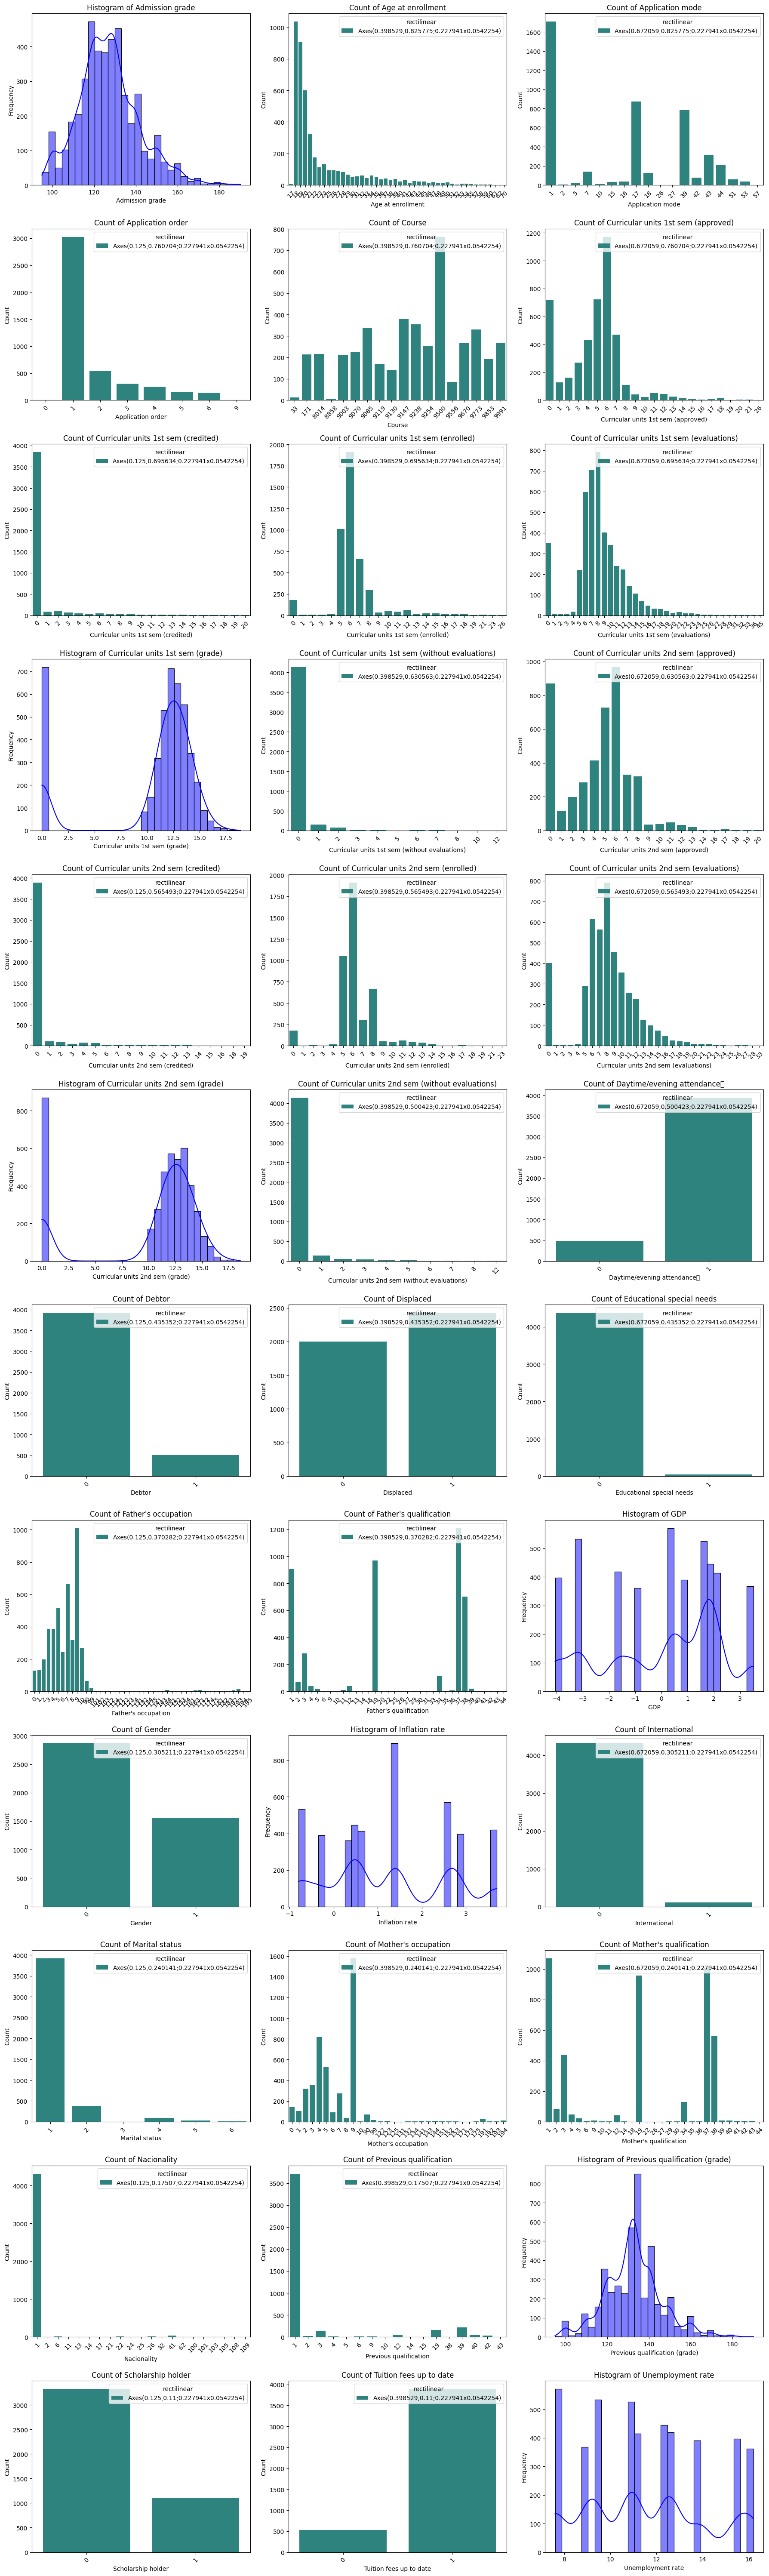

In [24]:
# Combine both for a single visualization layout
float_columns = df3.select_dtypes(['float64'])
int_columns = df3.select_dtypes(['int64'])
numerical_columns = float_columns + int_columns
all_columns = list(numerical_columns)

# Define the layout
columns_per_row = 3  # Number of plots per row
num_columns = len(all_columns)
num_rows = math.ceil(num_columns / columns_per_row)
# Create subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(18, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot each attribute
for idx, column in enumerate(all_columns):
    ax = axes[idx]
    
    if column in float_columns:
        # Plot histograms with KDE for numerical columns
        sns.histplot(df3[column], kde=True, ax=ax, bins=30, color='blue')
        ax.set_title(f"Histogram of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
    elif column in int_columns:
        # Plot count plots for categorical columns
        sns.countplot(x=df3[column], ax=ax, palette="viridis", hue=ax)
        ax.set_title(f"Count of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        # Rotate labels for better visibility
        ax.tick_params(axis='x', rotation=45)
    elif column in categorical_columns:
        # Plot count plots for categorical columns
        sns.countplot(x=df3[column], ax=ax, palette="viridis", hue=ax)
        ax.set_title(f"Count of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        # Rotate labels for better visibility
        ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for idx in range(num_columns, len(axes)):
    axes[idx].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

#### Box plot relation between numerical and Target

C:\Users\nasih\AppData\Local\Temp\ipykernel_39064\948048663.py:12: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


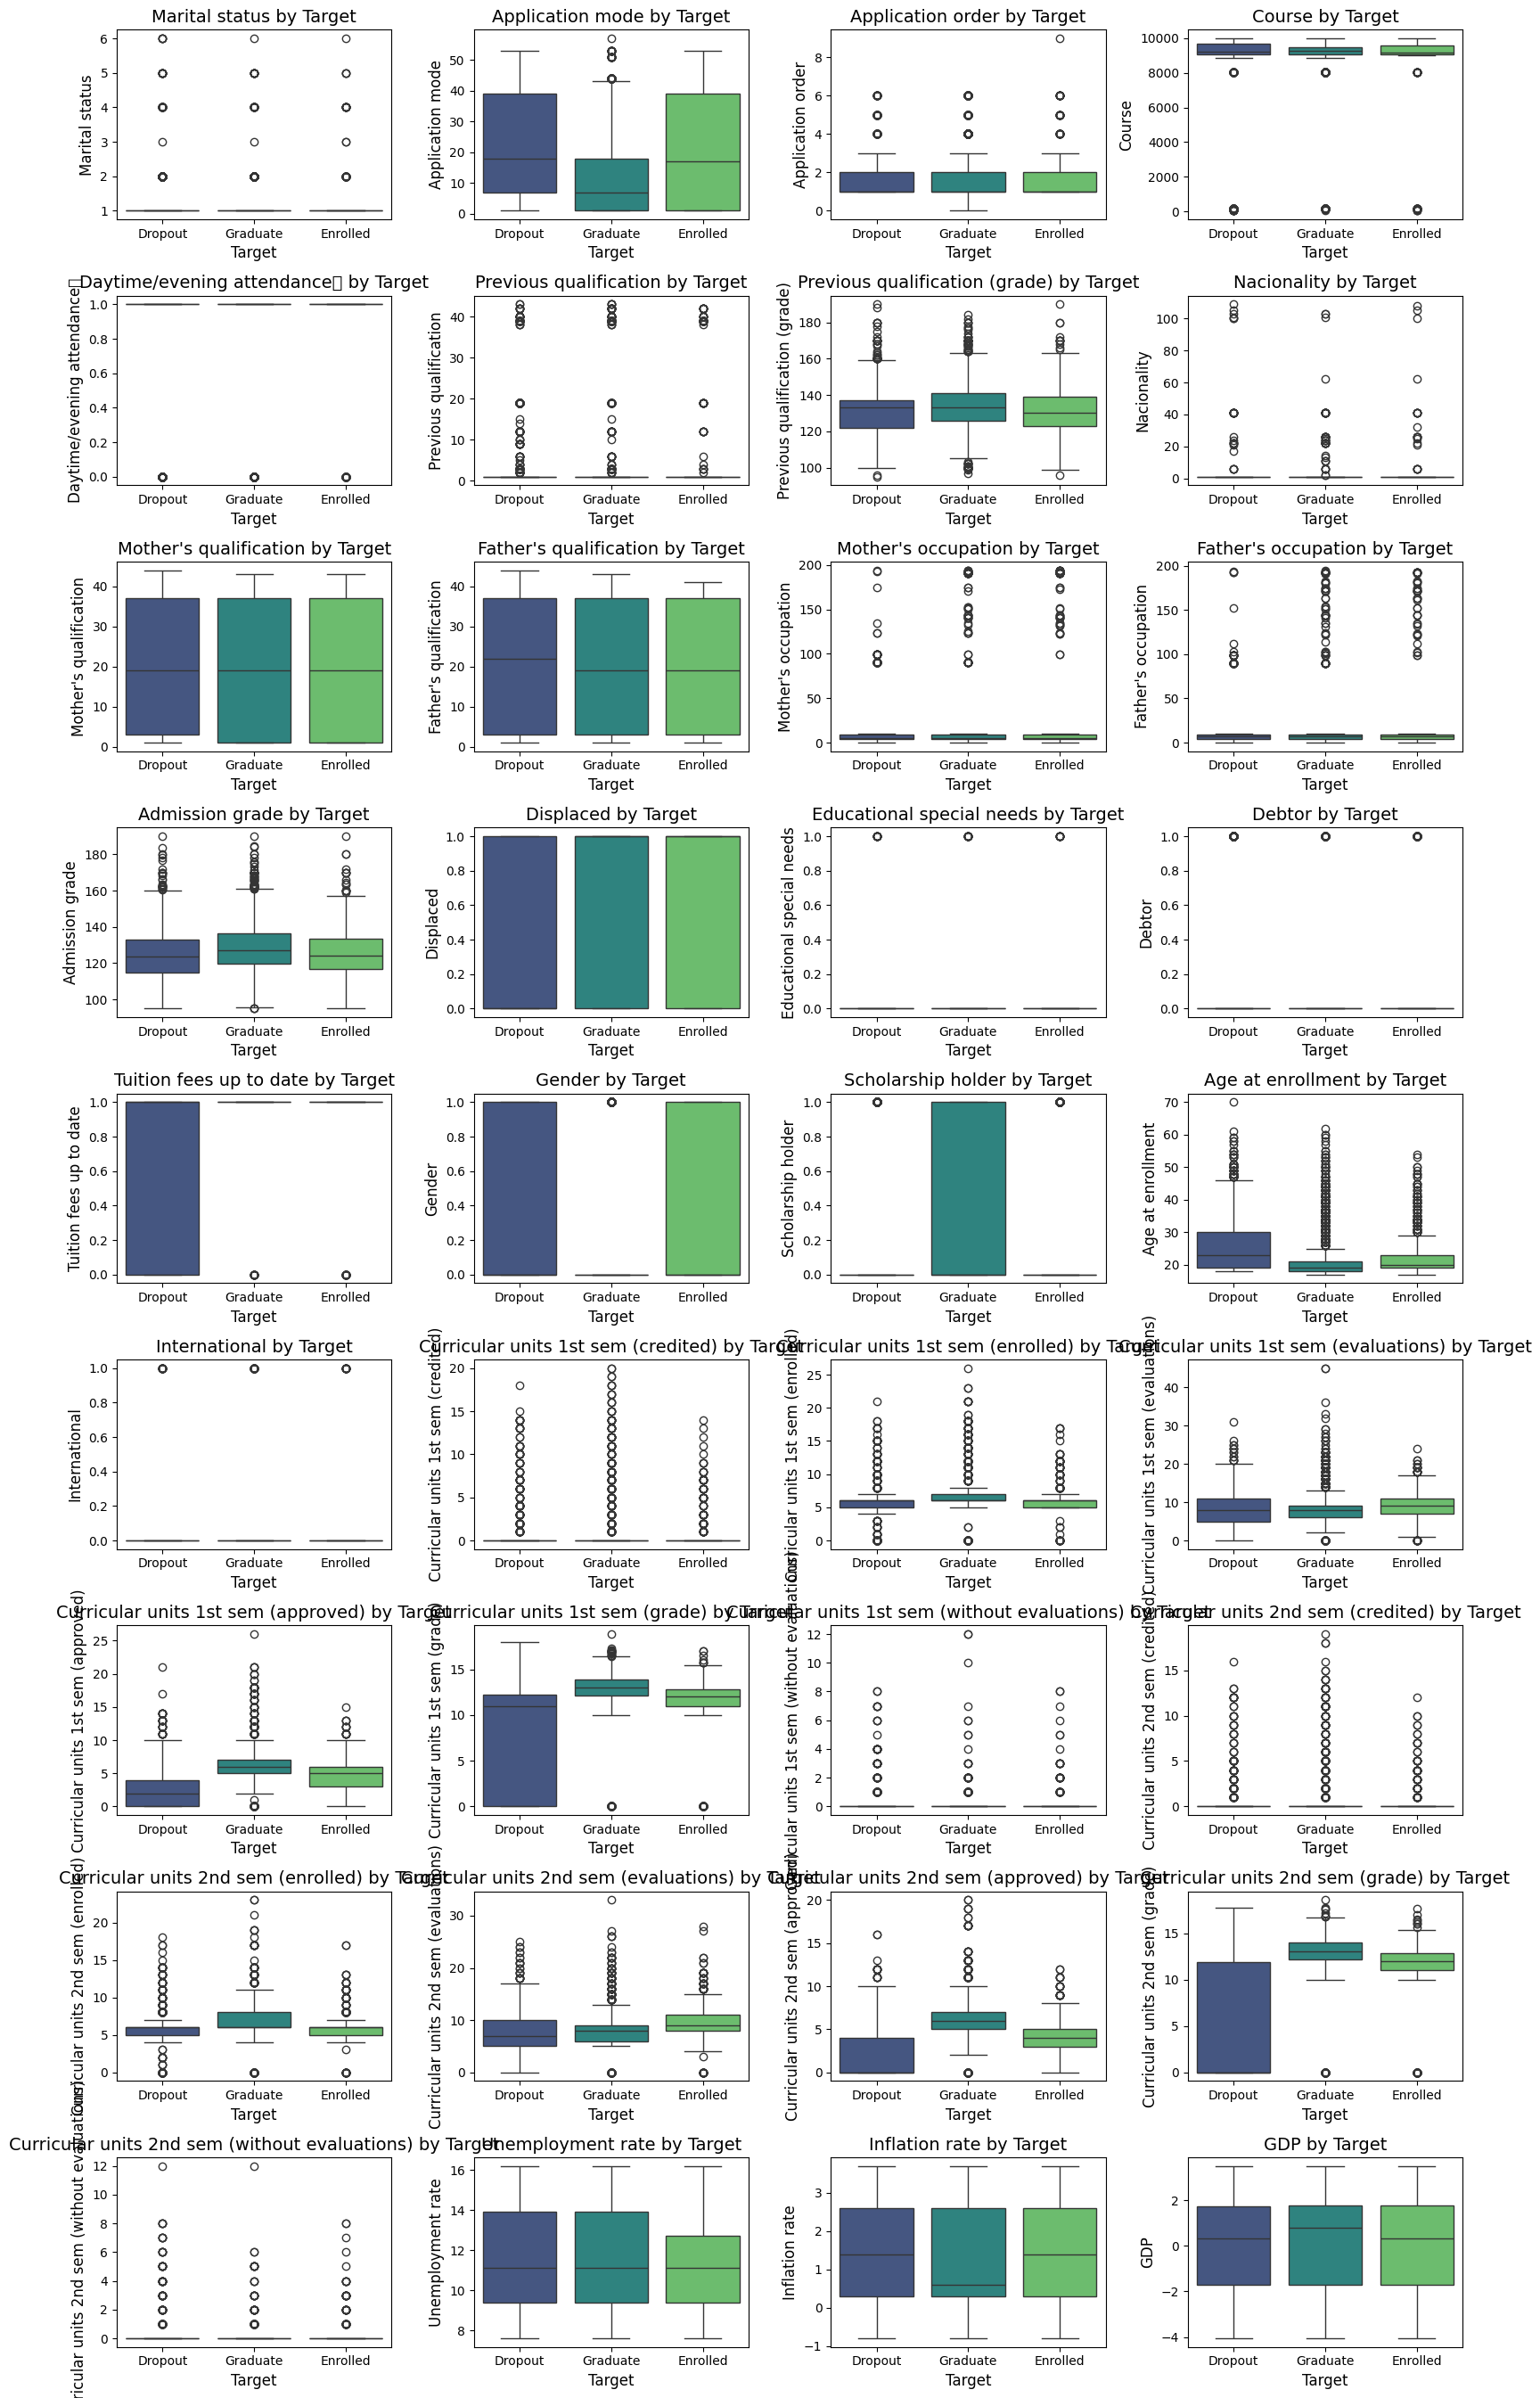

In [62]:
num_columns = 4
num_rows = math.ceil(len(numerical_columns) / num_columns)

plt.figure(figsize=(16, num_rows * 3))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(data=df3, x='Target', y=feature, palette="viridis")
    plt.title(f"{feature} by Target", fontsize=14)
    plt.xlabel("Target", fontsize=12)
    plt.ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()


### Spliting data
#### - To avoid data leakage before balancing

In [25]:
# Assuming 'data' is already loaded and contains the 'Target' column
X = df3.drop('Target', axis=1)
y = df3['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0, stratify=y)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Create a balanced dataset
balanced_data = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.DataFrame(y_balanced, columns=['Target'])], axis=1)

# Save balanced data to a CSV file
balanced_output_path = 'Student_dataset_balanced.csv'
balanced_data.to_csv(balanced_output_path, index=False)
print(f"Balanced data saved to {balanced_output_path}")

Balanced data saved to Student_dataset_balanced.csv


In [26]:
# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)


Categorical Columns: Index([], dtype='object')
Numerical Columns: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       '

##### The average accurary of the model should be quite high. Now let's evaluate the model with the test data. Our set of test data was not normalized yet, so lets do that first then get the average accuracy using the score function:

In [27]:
# Convert X_train back to a DataFrame
X_train_preprocess = pd.DataFrame(X, columns=X.columns)

# Normalize numerical attributes using MinMaxScaler
min_max_scaler = MinMaxScaler()
num_attributes = X_train_preprocess.select_dtypes(['int64', 'float64']).columns  # Identify numerical columns
X_train_preprocess[num_attributes] = min_max_scaler.fit_transform(X_train_preprocess[num_attributes])

# Display the preprocessed DataFrame
X_train_preprocess.head()

Marital status  Application mode  Application order    Course  \
0             0.0          0.285714           0.555556  0.013858   
1             0.0          0.250000           0.111111  0.925989   
2             0.0          0.000000           0.555556  0.907512   
3             0.0          0.285714           0.222222  0.978108   
4             0.2          0.678571           0.111111  0.801466   

   Daytime/evening attendance\t  Previous qualification  \
0                           1.0                     0.0   
1                           1.0                     0.0   
2                           1.0                     0.0   
3                           1.0                     0.0   
4                           0.0                     0.0   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                        0.284211          0.0                0.418605   
1                        0.684211          0.0                0.000000   
2                        0.284211          0.0                0.837209   
3                        0.284211          0.0                0.860465   
4                        0.052632          0.0                0.837209   

   Father's qualification  ...  \
0                0.255814  ...   
1                0.046512  ...   
2                0.837209  ...   
3                0.837209  ...   
4                0.860465  ...   

   Curricular units 1st sem (without evaluations)  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                  0.0                              0.00000   
1                                  0.0                              0.26087   
2                                  0.0                              0.26087   
3                                  0.0                              0.26087   
4                                  0.0                              0.26087   

   Curricular units 2nd sem (evaluations)  \
0                                0.000000   
1                                0.181818   
2                                0.000000   
3                                0.303030   
4                                0.181818   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                 0.00                          0.000000   
1                                 0.30                          0.735897   
2                                 0.00                          0.000000   
3                                 0.25                          0.667692   
4                                 0.30                          0.700000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                             0.0           0.372093   
1                                             0.0           0.732558   
2                                             0.0           0.372093   
3                                             0.0           0.209302   
4                                             0.0           0.732558   

   Inflation rate       GDP  
0        0.488889  0.766182  
1        0.111111  0.640687  
2        0.488889  0.766182  
3        0.000000  0.124174  
4        0.111111  0.640687  

[5 rows x 36 columns]

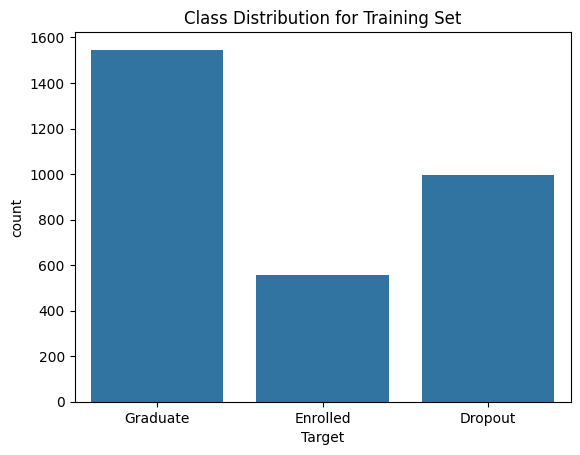

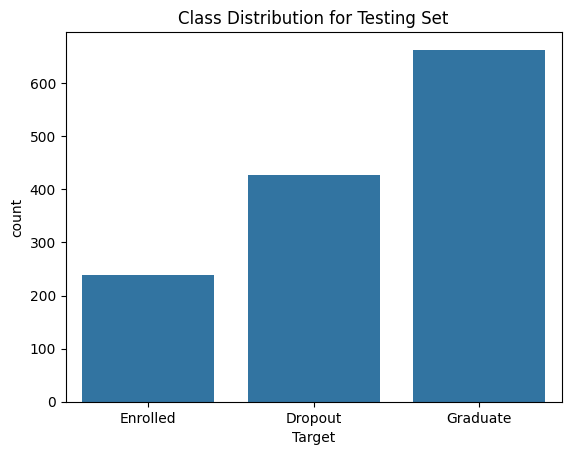

In [28]:
#visualize classes after splitting
plt.figure()
sns.countplot(x='Target', data = pd.DataFrame({'Target':y_train}))
plt.title('Class Distribution for Training Set')
plt.show()
plt.figure()
sns.countplot(x='Target', data = pd.DataFrame({'Target':y_test}))
plt.title('Class Distribution for Testing Set')
plt.show()

##### Right after we finish splitting, we can proceed to balance the training set using SMOTE.
##### For the current dataset, we have both numerical and categorical attributes. Therefore, we need to use SMOTENC, which requires the numerical data to be normalized, and also need to explicitly specify the index of the categorical columns. The following code extracts the indices of categorical columns and then normalizes the numerical values:

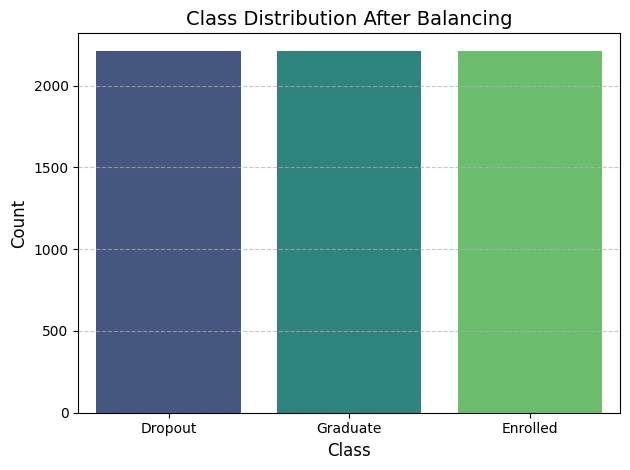

In [29]:
plt.figure()
sns.countplot(
    data=balanced_data, 
    x='Target', 
    hue='Target',  # Assign 'Target' to hue to match the palette
    palette='viridis',
    dodge=False,  # Ensures bars are not separated
    legend=False  # Removes the legend since it's redundant
)
plt.title('Class Distribution After Balancing', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Classification Tasks

In [30]:
# logistic regression
# decision trees
# support vector machines (svm)
# k-nearest neighbors (knn)
# random forest

Up until this point we current have a balanced training dataset, and a testing set for evaluation. In this section, we will train various classifiers, evaluate and compare the results. Most traditional classifiers are available in the scikit-learn package, but there are also alternatives available from other packages like Statsmodel, etc. Depending on the type of classifiers selected, additionally preprocessing might be needed to convert the attributes into the required type.

## Logistic Regression

#### Training accuracy

In [31]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Check performance on the training set
print('Training accuracy: ', logreg.score(X_train_scaled, y_train))

Training accuracy:  0.7719638242894057


#### Testing Accuracy

In [32]:
print('Testing accuracy: ', logreg.score(X_test_scaled, y_test) )

Testing accuracy:  0.759789156626506


### Confusion Matrix

Logistic Regression Performance:
              precision    recall  f1-score   support

     Dropout       0.80      0.76      0.78       427
    Enrolled       0.49      0.29      0.37       238
    Graduate       0.79      0.92      0.85       663

    accuracy                           0.76      1328
   macro avg       0.69      0.66      0.67      1328
weighted avg       0.74      0.76      0.74      1328

Accuracy: 0.759789156626506


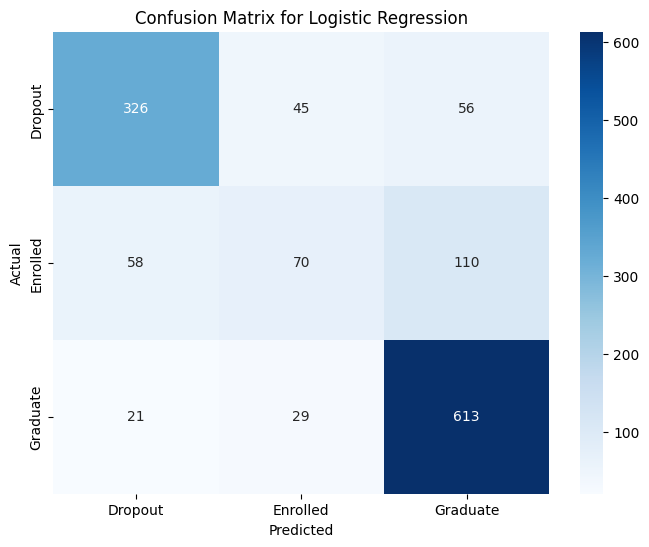

In [33]:
# Predict the labels for the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
# Train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg')
logistic_model.fit(X_balanced, y_balanced)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
logistic_report = classification_report(y_test, y_pred, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True)

# Convert the report to a DataFrame
logistic_regression_report_df = pd.DataFrame(logistic_report).transpose()

logistic_regression_report_df

precision    recall  f1-score      support
Dropout        0.860724  0.723653  0.786260   427.000000
Enrolled       0.462783  0.600840  0.522852   238.000000
Graduate       0.840909  0.837104  0.839002   663.000000
accuracy       0.758283  0.758283  0.758283     0.758283
macro avg      0.721472  0.720533  0.716038  1328.000000
weighted avg   0.779514  0.758283  0.765384  1328.000000

In [35]:
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# Check if it's binary classification (2x2 matrix)
if conf_mat.shape == (2, 2):
    tn, fp, fn, tp = conf_mat.ravel()
    print('True positive: ', tp)
    print('True negatives: ', tn)
    print('False positive: ', fp)
    print('False negatives: ', fn)
else:
    # Multi-class classification
    print("Multi-class confusion matrix, cannot unpack directly.")
    for i in range(conf_mat.shape[0]):
        print(f"Metrics for Class {i}:")
        tp = conf_mat[i, i]
        fn = conf_mat[i, :].sum() - tp
        fp = conf_mat[:, i].sum() - tp
        tn = conf_mat.sum() - (tp + fn + fp)
        print(f"  True Positives: {tp}")
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")

[[309  78  40]
 [ 30 143  65]
 [ 20  88 555]]
Multi-class confusion matrix, cannot unpack directly.
Metrics for Class 0:
  True Positives: 309
  True Negatives: 851
  False Positives: 50
  False Negatives: 118
Metrics for Class 1:
  True Positives: 143
  True Negatives: 924
  False Positives: 166
  False Negatives: 95
Metrics for Class 2:
  True Positives: 555
  True Negatives: 560
  False Positives: 105
  False Negatives: 108


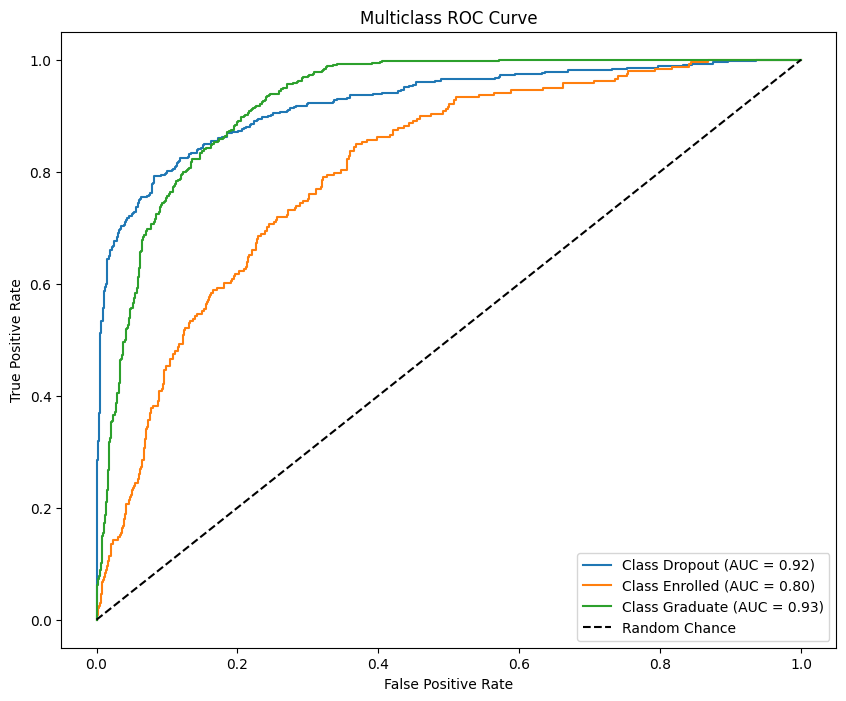

In [36]:
# Binarize the target variable for multiclass ROC
classes = logreg.classes_
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba = logreg.predict_proba(X_test_scaled)  # Get prediction probabilities

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="best")
plt.show()

### K-Nearest Neighbors

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [38]:
#Testing time may take long
print('Training accuracy: ', knn.score(X_train_scaled,y_train))
print('Testing accuracy: ', knn.score(X_test_scaled, y_test))

Training accuracy:  0.792312661498708
Testing accuracy:  0.6875


In [39]:
knn_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

     Dropout       0.77      0.67      0.72       427
    Enrolled       0.37      0.27      0.31       238
    Graduate       0.72      0.84      0.78       663

    accuracy                           0.69      1328
   macro avg       0.62      0.60      0.60      1328
weighted avg       0.67      0.69      0.68      1328



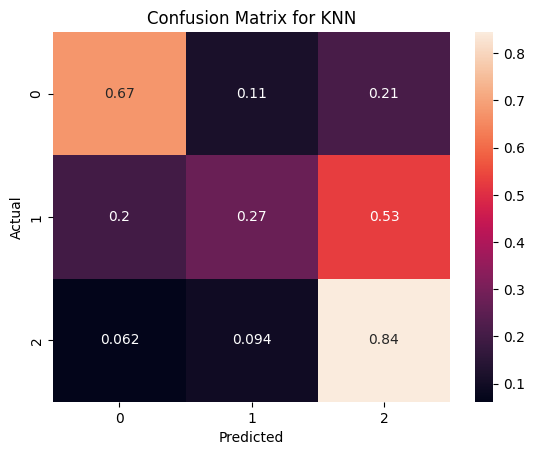

In [40]:
knn_conf_mat = confusion_matrix(y_test, knn_pred,normalize='true')
sns.heatmap(knn_conf_mat, annot=True)
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
print(f"Length of y_test: {len(y_test)}")
print(f"Length of knn_pred: {len(knn_pred)}")

Length of y_test: 1328
Length of knn_pred: 1328


In [42]:
# Evaluate the model
knn_report = classification_report(
    y_test, knn_pred, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True
)

# Convert the report to a DataFrame
knn_report_df = pd.DataFrame(knn_report).transpose()

knn_report_df

precision    recall  f1-score    support
Dropout        0.765957  0.674473  0.717310   427.0000
Enrolled       0.369318  0.273109  0.314010   238.0000
Graduate       0.721649  0.844646  0.778318   663.0000
accuracy       0.687500  0.687500  0.687500     0.6875
macro avg      0.618975  0.597409  0.603213  1328.0000
weighted avg   0.672752  0.687500  0.675490  1328.0000

In [43]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for K
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# GridSearchCV to find the best K
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# Evaluate the best model
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
print("\nClassification Report for Best KNN:")
classification_report(y_test, y_pred_best)

Best Parameters: {'n_neighbors': 11}
Best Cross-Validated Accuracy: 0.7018729480431498

Classification Report for Best KNN:


'              precision    recall  f1-score   support\n\n     Dropout       0.83      0.66      0.73       427\n    Enrolled       0.42      0.20      0.27       238\n    Graduate       0.69      0.92      0.79       663\n\n    accuracy                           0.70      1328\n   macro avg       0.65      0.59      0.60      1328\nweighted avg       0.69      0.70      0.68      1328\n'

### Support Vector Machine (SVM)

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42,)
svm_model.fit(X_train_scaled, y_train)
# Encode labels again if needed
label_encoder = LabelEncoder()
y_pca = label_encoder.fit_transform(y_train)
# Encode labels again if needed

In [45]:
# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7522590361445783

Classification Report:
               precision    recall  f1-score   support

     Dropout       0.82      0.71      0.76       427
    Enrolled       0.52      0.31      0.39       238
    Graduate       0.76      0.94      0.84       663

    accuracy                           0.75      1328
   macro avg       0.70      0.65      0.66      1328
weighted avg       0.74      0.75      0.73      1328


Confusion Matrix:
 [[302  48  77]
 [ 47  74 117]
 [ 19  21 623]]


In [46]:
# Evaluate the model
svm_report = classification_report(y_test, y_pred, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True)

# Convert the report to a DataFrame
svm_report_df = pd.DataFrame(svm_report).transpose()

svm_report_df

precision    recall  f1-score      support
Dropout        0.820652  0.707260  0.759748   427.000000
Enrolled       0.517483  0.310924  0.388451   238.000000
Graduate       0.762546  0.939668  0.841892   663.000000
accuracy       0.752259  0.752259  0.752259     0.752259
macro avg      0.700227  0.652617  0.663364  1328.000000
weighted avg   0.737310  0.752259  0.734216  1328.000000

In [47]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (3096, 36)
X_test_scaled shape: (1328, 36)


### Decision Trees

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree # Import Decision Tree Classifier and plotting function

clf = DecisionTreeClassifier()
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [49]:
#First split to get 20% as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#Split the training set again to get the validation set (requires calculation the get the needed percentage)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)
# 12.5% of 80% is 10% of the whole dataset (0.125 x 0.8 = 0.1)

print('Training set: ', y_train.shape)
print('Validation set: ', y_val.shape)
print('Testing set: ', y_test.shape)

Training set:  (3096,)
Validation set:  (443,)
Testing set:  (885,)


In [50]:
# Train Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Predict on the test set
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
decision_tree_report = classification_report(y_test, y_pred_dt, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True)

# Convert the report to a DataFrame
decision_tree_report_df = pd.DataFrame(decision_tree_report).transpose()

decision_tree_report_df

precision    recall  f1-score     support
Dropout        0.718631  0.689781  0.703911  274.000000
Enrolled       0.394444  0.425150  0.409222  167.000000
Graduate       0.789593  0.786036  0.787810  444.000000
accuracy       0.688136  0.688136  0.688136    0.688136
macro avg      0.634223  0.633656  0.633648  885.000000
weighted avg   0.693058  0.688136  0.690395  885.000000

In [51]:
# perform k-fold cross validation (with k=5 or k=10) for all classifiers to ensure robust performance evaluation. 
# report the following metrics based on cross-validation: Accuracy, Precision, Recall, F1-Score

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
# Train Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
rf_report = classification_report(
    y_test, y_pred_rf, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True
)

# Convert the report to a DataFrame
rf_report_df = pd.DataFrame(rf_report).transpose()

rf_report_df

precision    recall  f1-score     support
Dropout        0.825581  0.777372  0.800752  274.000000
Enrolled       0.628866  0.365269  0.462121  167.000000
Graduate       0.798113  0.952703  0.868583  444.000000
accuracy       0.787571  0.787571  0.787571    0.787571
macro avg      0.750854  0.698448  0.710485  885.000000
weighted avg   0.774680  0.787571  0.770883  885.000000

## Advanced Ensemble Method

### Bagging (Bagged Decision Trees)

In [53]:
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
bagging_report = classification_report(y_test, y_pred_bagging, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True)
bagging_report_df = pd.DataFrame(bagging_report).transpose()
bagging_report_df

precision    recall  f1-score     support
Dropout        0.818182  0.722628  0.767442  274.000000
Enrolled       0.516667  0.371257  0.432056  167.000000
Graduate       0.791587  0.932432  0.856256  444.000000
accuracy       0.761582  0.761582  0.761582    0.761582
macro avg      0.708812  0.675439  0.685251  885.000000
weighted avg   0.747943  0.761582  0.748712  885.000000

### Gradient Boost

In [54]:
# Train Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
gradient_boosting_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gradient_boosting_model.predict(X_test)

# Evaluate the model
gb_report = classification_report(
    y_test, y_pred_gb, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True
)

# Convert the report to a DataFrame
gb_report_df = pd.DataFrame(gb_report).transpose()

gb_report_df

precision    recall  f1-score     support
Dropout        0.853061  0.762774  0.805395  274.000000
Enrolled       0.575000  0.413174  0.480836  167.000000
Graduate       0.801923  0.939189  0.865145  444.000000
accuracy       0.785311  0.785311  0.785311    0.785311
macro avg      0.743328  0.705046  0.717125  885.000000
weighted avg   0.774935  0.785311  0.774127  885.000000

### XGBoost

In [55]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost model with encoded labels
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Decode predictions back to original labels for evaluation
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate the model
xgb_report = classification_report(
    y_test, y_pred_xgb_decoded, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True
)

# Convert the report to a DataFrame
xgb_report_df = pd.DataFrame(xgb_report).transpose()

xgb_report_df

precision    recall  f1-score     support
Dropout        0.822835  0.762774  0.791667  274.000000
Enrolled       0.560345  0.389222  0.459364  167.000000
Graduate       0.803883  0.932432  0.863399  444.000000
accuracy       0.777401  0.777401  0.777401    0.777401
macro avg      0.729021  0.694809  0.704810  885.000000
weighted avg   0.763795  0.777401  0.764949  885.000000

### AdaBoost

In [56]:
adaboost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                                    n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)
adaboost_report = classification_report(y_test, y_pred_adaboost, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True)
adaboost_report_df = pd.DataFrame(adaboost_report).transpose()
adaboost_report_df

precision    recall  f1-score     support
Dropout        0.779528  0.722628  0.750000  274.000000
Enrolled       0.507937  0.383234  0.436860  167.000000
Graduate       0.798020  0.907658  0.849315  444.000000
accuracy       0.751412  0.751412  0.751412    0.751412
macro avg      0.695161  0.671173  0.678725  885.000000
weighted avg   0.737556  0.751412  0.740736  885.000000

### Cross Validation and Evaluation

In [57]:
# Adjusted function to handle both dictionary and DataFrame formats
def extract_metrics(report, model_name):
    if isinstance(report, pd.DataFrame):
        # Handle DataFrame format
        model_results[model_name] = {
            'Accuracy': report.loc['accuracy', 'f1-score'] * 100 if 'accuracy' in report.index else 0,
            'Macro Avg Precision': report.loc['macro avg', 'precision'] * 100 if 'macro avg' in report.index else 0,
            'Macro Avg Recall': report.loc['macro avg', 'recall'] * 100 if 'macro avg' in report.index else 0,
            'Macro Avg F1-Score': report.loc['macro avg', 'f1-score'] * 100 if 'macro avg' in report.index else 0
        }
    else:
        # Handle dictionary format
        model_results[model_name] = {
            'Accuracy': report['accuracy'] * 100 if 'accuracy' in report else 0,
            'Macro Avg Precision': report['macro avg']['precision'] * 100 if 'macro avg' in report else 0,
            'Macro Avg Recall': report['macro avg']['recall'] * 100 if 'macro avg' in report else 0,
            'Macro Avg F1-Score': report['macro avg']['f1-score'] * 100 if 'macro avg' in report else 0
        }

# Extract metrics for each model
model_results = {}
extract_metrics(logistic_regression_report_df, 'Logistic Regression')
extract_metrics(decision_tree_report_df, 'Decision Tree')
extract_metrics(svm_report_df, 'SVM')
extract_metrics(knn_report_df, 'KNN')
extract_metrics(rf_report_df, 'Random Forest')
extract_metrics(bagging_report_df, 'Bagging')
extract_metrics(gb_report_df, 'Gradient Boosting')
extract_metrics(xgb_report_df, 'XGBoost')
extract_metrics(adaboost_report_df, 'AdaBoost')

# Convert results to a DataFrame
summary_df_dynamic = pd.DataFrame.from_dict(model_results, orient='index')
summary_df_dynamic

Accuracy  Macro Avg Precision  Macro Avg Recall  \
Logistic Regression  75.828313            72.147217         72.053260   
Decision Tree        68.813559            63.422279         63.365559   
SVM                  75.225904            70.022686         65.261750   
KNN                  68.750000            61.897504         59.740929   
Random Forest        78.757062            75.085353         69.844814   
Bagging              76.158192            70.881183         67.543922   
Gradient Boosting    78.531073            74.332810         70.504552   
XGBoost              77.740113            72.902099         69.480924   
AdaBoost             75.141243            69.516129         67.117298   

                     Macro Avg F1-Score  
Logistic Regression           71.603791  
Decision Tree                 63.364763  
SVM                           66.336392  
KNN                           60.321268  
Random Forest                 71.048542  
Bagging                       68.525136  
Gradient Boosting             71.712549  
XGBoost                       70.481000  
AdaBoost                      67.872505

### Implement K-fold cross-validation for additional robustness

In [58]:
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress warnings

# Check class distribution
print(df2['Target'].value_counts())

# Prepare features (X) and target (y)
X = df2.drop(columns=['Target'])  # Drop the target column
y = df2['Target']  # Target column

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Update StratifiedKFold to use appropriate n_splits
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Dictionary to store average cross-validation results
cv_results = {}

# Function to perform k-fold cross-validation
def evaluate_model(model, X, y, model_name):
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    scores = {}
    for metric, scorer in scoring.items():
        score = cross_val_score(model, X, y, cv=kf, scoring=scorer, n_jobs=-1)  # Parallelized
        scores[metric] = score.mean() * 100  # Convert to percentage
    cv_results[model_name] = scores

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
        n_estimators=50,
        learning_rate=1.0,
        algorithm='SAMME',  # Updated to SAMME
        random_state=42
    )
}

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    evaluate_model(model, X_scaled, y_encoded, model_name)  # Use scaled features

# Convert results to DataFrame
cv_results_df = pd.DataFrame(cv_results).transpose()

# Display the results
# Option 1: Print the DataFrame
print(cv_results_df)

# Option 2: Save to a CSV file for further analysis
cv_results_df.to_csv('cv_k-fold_results.csv', index=True)
print("Cross-validation results saved to 'cv_k-fold_results.csv'.")

Target
Graduate    2221
Dropout     1427
Enrolled     798
Name: count, dtype: int64
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating SVM...
Evaluating KNN...
Evaluating Random Forest...
Evaluating Bagging...
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating AdaBoost...
                      accuracy  precision     recall         f1
Logistic Regression  76.428250  70.320794  66.654034  67.340143
Decision Tree        68.286100  61.600712  61.674130  61.602354
SVM                  76.360774  70.938216  67.219881  68.254120
KNN                  70.062978  62.718168  60.470859  60.938409
Random Forest        77.440396  72.863491  68.060601  69.120490
Bagging              76.698156  71.284877  68.248291  69.157191
Gradient Boosting    77.620333  72.807904  69.172516  70.211087
XGBoost              77.620333  72.475562  69.609303  70.520117
AdaBoost             74.426451  67.116475  63.912069  63.904935
Cross-validation results saved to 'cv_k-fold_result

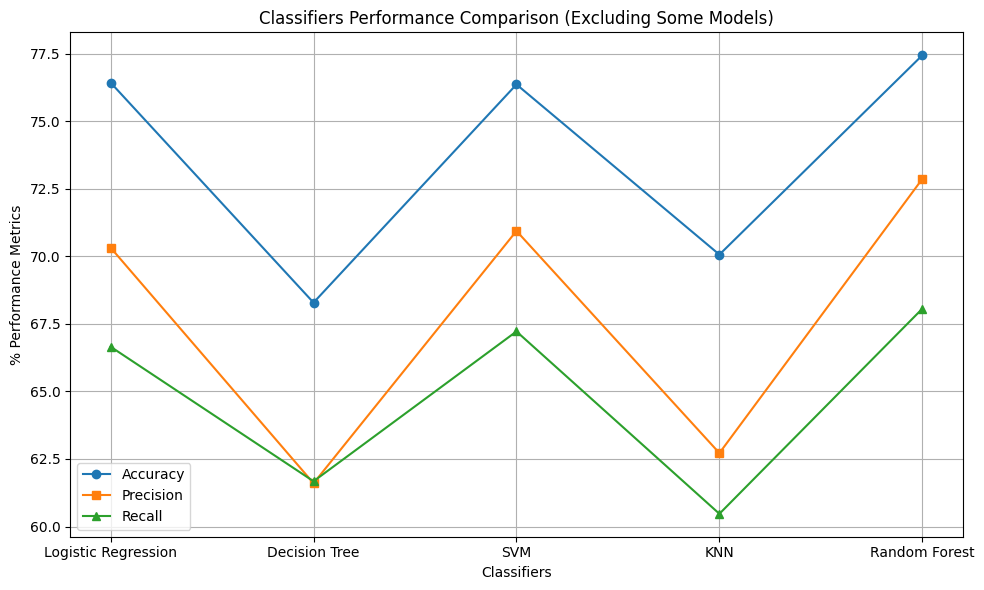

In [59]:
# Load the cross-validation results from the CSV file
cv_results_df = pd.read_csv('cv_k-fold_results.csv', index_col=0)

# Exclude specified classifiers
excluded_classifiers = ['Bagging', 'Gradient Boosting', 'XGBoost','AdaBoost']
filtered_df = cv_results_df[~cv_results_df.index.isin(excluded_classifiers)]

# Select the metric to be used for the x-axis
x_axis_metric = 'classifiers'  # Options: 'classifiers', 'accuracy', 'precision', 'recall'

# Prepare the x-axis data
if x_axis_metric == 'classifiers':
    x_data = filtered_df.index.tolist()
else:
    x_data = filtered_df[x_axis_metric].tolist()

# Extract data for the plot
accuracy = filtered_df['accuracy'].tolist()
precision = filtered_df['precision'].tolist()
recall = filtered_df['recall'].tolist()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(x_data, accuracy, marker='o', linestyle='-', label='Accuracy')
plt.plot(x_data, precision, marker='s', linestyle='-', label='Precision')
plt.plot(x_data, recall, marker='^', linestyle='-', label='Recall')

# Add labels, title, and legend
plt.title('Classifiers Performance Comparison (Excluding Some Models)')
plt.xlabel(x_axis_metric.capitalize())
plt.ylabel('% Performance Metrics')
plt.legend(loc='best')

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

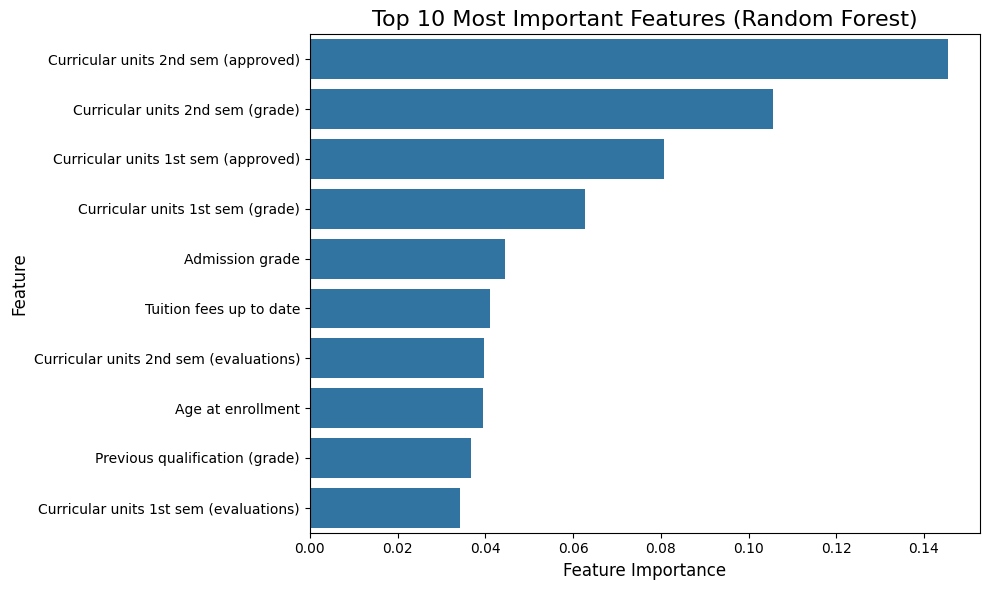

Top 10 Important Features:
                                           Feature  Importance
30             Curricular units 2nd sem (approved)    0.145491
31                Curricular units 2nd sem (grade)    0.105546
24             Curricular units 1st sem (approved)    0.080815
25                Curricular units 1st sem (grade)    0.062720
12                                 Admission grade    0.044469
16                         Tuition fees up to date    0.041075
29          Curricular units 2nd sem (evaluations)    0.039715
19                               Age at enrollment    0.039513
6                   Previous qualification (grade)    0.036860
23          Curricular units 1st sem (evaluations)    0.034298
3                                           Course    0.032909
11                             Father's occupation    0.029708
10                             Mother's occupation    0.026652
35                                             GDP    0.024233
33                          

In [60]:
# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X_balanced.columns,
    'Importance': random_forest_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')  # Removed `palette`
plt.title('Top 10 Most Important Features (Random Forest)', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Display the top features as a DataFrame
print("Top 10 Important Features:")
print(feature_importances.head(40))

In [61]:
# Select the top 10 features based on importance
top_features = feature_importances['Feature'].head(10).values
X_train_top = X_balanced[top_features]
X_test_top = X_test[top_features]

# Train Random Forest model with selected features
rf_model_top_features = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_top_features.fit(X_train_top, y_balanced)

# Predict on the test set
y_pred_rf_top = rf_model_top_features.predict(X_test_top)

# Evaluate the model
rf_top_report = classification_report(
    y_test, y_pred_rf_top, target_names=['Dropout', 'Enrolled', 'Graduate'], output_dict=True
)

# Convert the report to a DataFrame
rf_top_report_df = pd.DataFrame(rf_top_report).transpose()

# Output the results
rf_top_report_df

precision  recall  f1-score  support
Dropout             1.0     1.0       1.0    274.0
Enrolled            1.0     1.0       1.0    167.0
Graduate            1.0     1.0       1.0    444.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    885.0
weighted avg        1.0     1.0       1.0    885.0